# Final Project Submission

* **Student name**: Sara Robinson
* **Student pace**: *self paced*/part time/full time
* **Scheduled project review date/time**: 9/7/2021 11:00
* **Instructor name**: Jeff Herman
* **Blog post URL**: https://medium.com/@sara.robinson27/classifying-a-tweets-sentiment-based-on-its-content-9835069aa2b3
* **Notebook**: 4/4

## Introduction

The purpose of this project is to build a model that can rate the sentiment of a tweet based on its content. The data is from CrowdFlower and contains over 9000 tweets about Apple and Google products rated by humans as either postive, negative, or neither.

This is the fourth notebook for the Phase 4 Final Project. This notebook follows the baseline models and picks up at tuning those baseline models and determining our best and final model.

## Import Libraries

In the following cells I import the necessary libraries for this notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, precision_recall_curve, auc, roc_curve
from sklearn.metrics import plot_confusion_matrix, cohen_kappa_score, matthews_corrcoef
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import collections
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import ast

## Load and Inspect Data

In the following cells I load the cleaned dataset that we explored in the previous notebook and check it to make sure everything is ready to be modeled.

In [2]:
df = pd.read_csv('CleanedDF.csv') #Read in dataset
df.head() #Checking first 5 rows

,Tweet,Product,Emotion,Brand,Tweet Character Count,Hashtag,Hashtag Count,Clean,Clean Character Count,Clean Tokens,Clean Token Count,Tweet Tokens,Tweet Token Count
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,Apple,127,"['#RISE_Austin', '#SXSW']",2,i have a g iphone after hrs tweeting at risea...,104,"['i', 'have', 'g', 'iphone', 'after', 'hrs', '...",16,"['.', '@wesley83', 'I', 'have', 'a', '3G', 'iP...",29
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Apple,139,['#SXSW'],1,know about awesome ipadiphone app that youll ...,112,"['know', 'about', 'awesome', 'ipadiphone', 'ap...",15,"['@jessedee', 'Know', 'about', '@fludapp', '?'...",26
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Apple,79,"['#iPad', '#SXSW']",2,can not wait for ipad also they should sale t...,61,"['can', 'not', 'wait', 'ipad', 'also', 'they',...",11,"['@swonderlin', 'Can', 'not', 'wait', 'for', '...",17
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,Apple,82,['#sxsw'],1,i hope this years festival isnt as crashy as ...,71,"['i', 'hope', 'years', 'festival', 'isnt', 'as...",12,"['@sxsw', 'I', 'hope', 'this', ""year's"", 'fest...",16
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,Google,131,['#SXSW'],1,great stuff on fri sxsw marissa mayer google ...,103,"['great', 'stuff', 'fri', 'sxsw', 'marissa', '...",14,"['@sxtxstate', 'great', 'stuff', 'on', 'Fri', ...",27


We'll do just as we did in the previous notebook and create a smaller dataframe that contains just the cleaned tokens and the rated emotions.

In [3]:
df['Clean Tokens'] = df['Clean Tokens'].map(ast.literal_eval) #converting list of strings as string to list of strings

data = df[['Clean Tokens', 'Emotion']] #Creating dataframe to use when modeling

data.head() #Checking new dataframe

,Clean Tokens,Emotion
0,"[i, have, g, iphone, after, hrs, tweeting, ris...",Negative
1,"[know, about, awesome, ipadiphone, app, youll,...",Positive
2,"[can, not, wait, ipad, also, they, should, sal...",Positive
3,"[i, hope, years, festival, isnt, as, crashy, a...",Negative
4,"[great, stuff, fri, sxsw, marissa, mayer, goog...",Positive


Everything looks good.

# Preparing to Tune and Model

Here we'll put the same functions that we're previously used to build and evaluate our models. We'll be using the same system we used in the previous notebook but again, this time we'll be going in and tuning each individual model.

In [4]:
def passthrough(doc): #Function to passthrough our pipelines
    return doc #returns same

def confmat_and_classrep(estimator, X, y, labels, set_name): #Function that prints confusion matrix and class report
    predictions = estimator.predict(X) #predicts from estimators
    print(f'Classification Report for {set_name} Set') #print classification report name
    print(classification_report(y, predictions, target_names = labels)) #print classification report numbers
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5)) #Making subplots for each matrix
    matrix = plot_confusion_matrix(estimator, X, y, display_labels = labels, cmap = plt.cm.viridis, 
                                  xticks_rotation = 70, values_format = 'd', ax = axes[0]) #plot non-normal matrix
    matrix.ax_.set_title(f'{set_name} Set Confusion Matrix, \n without Normalization') #setting title of non-normal
    matrix = plot_confusion_matrix(estimator, X, y, display_labels = labels, cmap = plt.cm.viridis, 
                                  xticks_rotation = 70, normalize = 'true', ax = axes[1]) #plot normal matrix
    matrix.ax_.set_title(f'{set_name} Set Confusion Matrix, \n with Normalization') #setting title of normal matrix
    plt.subplots_adjust(wspace = 0.5) #Adding space between graphs
    plt.show() #Showing matrix
    
    print(f'{set_name} Accuracy: {estimator.score(X, y):.2%}')
    print('')
    
    print(f"Cohen's Kappa Score for {set_name} Set:")
    print(round(cohen_kappa_score(y, predictions), 3))
    print('')
    
    print(f"Matthew's Correlation Coefficient for {set_name} Set:")
    print(round(matthews_corrcoef(y, predictions), 3))
    
def pr_curves(y_test_multi, y_hat_test_multi, classes): #Function that prints precision recall curves
    precision = dict() #creating dict of precision scores
    recall = dict() #creating dict of recall scores
    pr_auc = dict() #creating dict of auc
    for i in range(3): #for loop
        precision[i], recall[i], _ = precision_recall_curve(y_test_multi[:, i], y_hat_test_multi[:, i]) #calling
        pr_auc[i] = auc(recall[i], precision[i]) #setting
    
    plt.figure()
    lw = 2
    colors = ['red', 'blue', 'green']
    
    for i, class_ in enumerate(classes):
        plt.plot(recall[i], precision[i], color = colors[i], lw = lw, 
                 label = f'{classes[i]}, PR Curve AUC: {round(pr_auc[i], 2)}')
    
    plt.plot([0, 1], [1, 0], 'k--') #setting plot with label
    plt.xlim([0.0, 1.0]) #setting limits of x
    plt.ylim([0.0, 1.05]) #setting limits of y
    plt.xlabel('Recall') #labeling x
    plt.ylabel('Precision') #labeling y
    plt.title('Precision Recall Curve') #setting title
    plt.legend(loc="lower left") #setting legend
    plt.show() #Showing graph
        
def roc_curves(y_test_multi, y_hat_test_multi, classes): #Function that prints roc curves
    fpr = dict() #creating dict of fpr
    tpr = dict() #creating dict of tpr
    roc_auc = dict() #Creating dict of auc
    for i in range(3): #for loop
        fpr[i], tpr[i], _ = roc_curve(y_test_multi[:, i], y_hat_test_multi[:, i]) #calling
        roc_auc[i] = auc(fpr[i], tpr[i]) #setting
    
    plt.figure()
    lw = 2
    colors = ['deeppink', 'royalblue', 'lawngreen']
    
    for i, class_ in enumerate(classes): #for loop to create singular graphs
        plt.plot(fpr[i], tpr[i], color = colors[i], lw = lw, 
                 label = f'{classes[i]}, ROC Curve AUC: {round(roc_auc[i], 2)}') #setting plot with label
        
    plt.plot([0, 1], [0, 1], 'k--') #setting plot with label
    plt.xlim([0.0, 1.0]) #setting limits of x
    plt.ylim([0.0, 1.05]) #setting limits of y
    plt.xlabel('False Positive Rate') #labeling x
    plt.ylabel('True Positive Rate') #labeling y
    plt.title('Receiver Operating Characteristic Curve') #setting title
    plt.legend(loc="lower right") #setting legend
    plt.show() #showing graph

In [5]:
X = data['Clean Tokens'] #Setting X
y = data['Emotion'] #Setting y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, 
                                                    random_state = 43, stratify = data['Emotion']) #Splitting data

display(X_train.shape) #Checking shape of X_train
display(y_train.shape) #Checking shape of y_train
display(X_test.shape) #Checking shape of X_test
display(y_test.shape) #Checking shape of y_test

(6802,)

(6802,)

(2268,)

(2268,)

Everything looks good, let's get started!

# Tuning our Models

Let's review our top five models we want to tune then make a plan:

* Logistic Regression using CountVectorizer
* Multinomial Naive Bayes using CountVectorizer
* Logistic Regression using TF-IDF Vectorizer
* Random Forest using TF-IDF Vectorizer
* Random Forest using Count Vectorizer

For each logistic regression model, let's first try setting class weight equal to balanced. Let's also separately try two different values for C (1e50 and 0.5), then let's try these new values of C with class weight equal to balanced. This means each logistic regression model will have five tuned models (our subtotal right now is 10 tuned models).

For the multinomial naive bayes model, we'll try three different values for alpha (0.001, 0.01, and 0.1). This means the multinomial naive bayes model will have three tuned models (our subtotal right now is 13 tuned models).

For each random forest model, we'll first try setting class weight equal to balanced. Let's also separately try a few different values for the number of estimators (10 and 50), then let's try these new values with class weight equal to balanced. This means each random forest model will have five tuned models (our subtotal now is 23 tuned models).

We'll also create another dataframe to compare all these scores again. I'm going to include the original five baseline models in this dataframe so we can compare them to the tuned models and see if the tuned models actually did perform better or not.

In [6]:
tunedscores_df = pd.DataFrame(columns = ['Model Name', 'Accuracy Score', 'Precision Score', 'Recall Score', 
                                        'F1 Score', "Cohen's Kappa Score", "Matthew's Correlation Coefficient", 
                                        'Neg PRC AUC Score', 'Neu PRC AUC Score', 'Pos PRC AUC Score', 
                                        'Neg ROC AUC Score', 'Neu ROC AUC Score', 'Pos ROC AUC Score'], 
                         index = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', 
                                 '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28'])

tunedscores_df.loc['1'] = pd.Series({'Model Name': 'LogRegCV', 'Accuracy Score': 0.69, 'Precision Score': 0.63, 
                                    'Recall Score': 0.55, 'F1 Score': 0.58, "Cohen's Kappa Score": 0.373, 
                                    "Matthew's Correlation Coefficient": 0.377, 'Neg PRC AUC Score': 0.34, 
                                    'Neu PRC AUC Score': 0.81, 'Pos PRC AUC Score': 0.63, 'Neg ROC AUC Score': 0.82, 
                                    'Neu ROC AUC Score': 0.75, 'Pos ROC AUC Score': 0.77}) #Inputting info

tunedscores_df.loc['2'] = pd.Series({'Model Name': 'MNBCV', 'Accuracy Score': 0.68, 'Precision Score': 0.66, 
                                    'Recall Score': 0.51, 'F1 Score': 0.54, "Cohen's Kappa Score": 0.342, 
                                    "Matthew's Correlation Coefficient": 0.345, 'Neg PRC AUC Score': 0.31, 
                                    'Neu PRC AUC Score': 0.80, 'Pos PRC AUC Score': 0.62, 'Neg ROC AUC Score': 0.78, 
                                    'Neu ROC AUC Score': 0.74, 'Pos ROC AUC Score': 0.75}) #Inputting info

tunedscores_df.loc['3'] = pd.Series({'Model Name': 'LogRegTF', 'Accuracy Score': 0.70, 'Precision Score': 0.64, 
                                    'Recall Score': 0.47, 'F1 Score': 0.49, "Cohen's Kappa Score": 0.341, 
                                    "Matthew's Correlation Coefficient": 0.359, 'Neg PRC AUC Score': 0.33, 
                                    'Neu PRC AUC Score': 0.82, 'Pos PRC AUC Score': 0.66, 'Neg ROC AUC Score': 0.83, 
                                    'Neu ROC AUC Score': 0.76, 'Pos ROC AUC Score': 0.77}) #Inputting info

tunedscores_df.loc['4'] = pd.Series({'Model Name': 'RFTV', 'Accuracy Score': 0.68, 'Precision Score': 0.65, 
                                    'Recall Score': 0.49, 'F1 Score': 0.52, "Cohen's Kappa Score": 0.304, 
                                    "Matthew's Correlation Coefficient": 0.324, 'Neg PRC AUC Score': 0.35, 
                                    'Neu PRC AUC Score': 0.79, 'Pos PRC AUC Score': 0.59, 'Neg ROC AUC Score': 0.80, 
                                    'Neu ROC AUC Score': 0.73, 'Pos ROC AUC Score': 0.74}) #Inputting info

tunedscores_df.loc['5'] = pd.Series({'Model Name': 'RFCV', 'Accuracy Score': 0.68, 'Precision Score': 0.66, 
                                    'Recall Score': 0.50, 'F1 Score': 0.54, "Cohen's Kappa Score": 0.302, 
                                    "Matthew's Correlation Coefficient": 0.321, 'Neg PRC AUC Score': 0.38, 
                                    'Neu PRC AUC Score': 0.80, 'Pos PRC AUC Score': 0.60, 'Neg ROC AUC Score': 0.83, 
                                    'Neu ROC AUC Score': 0.74, 'Pos ROC AUC Score': 0.75}) #Inputting info

tunedscores_df.head() #Checking to make sure df was created

,Model Name,Accuracy Score,Precision Score,Recall Score,F1 Score,Cohen's Kappa Score,Matthew's Correlation Coefficient,Neg PRC AUC Score,Neu PRC AUC Score,Pos PRC AUC Score,Neg ROC AUC Score,Neu ROC AUC Score,Pos ROC AUC Score
1,LogRegCV,0.69,0.63,0.55,0.58,0.373,0.377,0.34,0.81,0.63,0.82,0.75,0.77
2,MNBCV,0.68,0.66,0.51,0.54,0.342,0.345,0.31,0.8,0.62,0.78,0.74,0.75
3,LogRegTF,0.7,0.64,0.47,0.49,0.341,0.359,0.33,0.82,0.66,0.83,0.76,0.77
4,RFTV,0.68,0.65,0.49,0.52,0.304,0.324,0.35,0.79,0.59,0.8,0.73,0.74
5,RFCV,0.68,0.66,0.5,0.54,0.302,0.321,0.38,0.8,0.6,0.83,0.74,0.75


Alright, our tuned scores df is made and our baseline model scores are all added. Let's get to tunin'!

## Logistic Regression using CountVectorizer

We'll be making five models here. One with class weight set to balanced, one with C set to 1e50, one with C set to 0.5, and we'll repeat those two C parameters with class weight set to balanced.

### Tuned Model 1: Class Weight = Balanced

In [7]:
le = LabelEncoder() #Instantiating Label Encoder
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T1LRpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with count vectorizer

T1LRpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 CountVectorizer(preprocessor=<function passthrough at 0x7fd4cb862e50>,
                                 tokenizer=<function passthrough at 0x7fd4cb862e50>)),
                ('Classifier', LogisticRegression(class_weight='balanced'))])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.80      1.00      0.89       427
     Neutral       0.95      0.89      0.92      4148
    Positive       0.84      0.91      0.88      2227

    accuracy                           0.90      6802
   macro avg       0.86      0.93      0.89      6802
weighted avg       0.91      0.90      0.90      6802



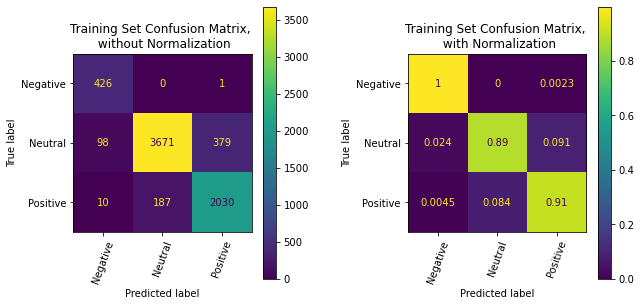

Training Accuracy: 90.08%

Cohen's Kappa Score for Training Set:
0.814

Matthew's Correlation Coefficient for Training Set:
0.816


In [8]:
confmat_and_classrep(T1LRpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #Evaluating train 1st tuned model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.39      0.48      0.43       142
     Neutral       0.77      0.72      0.74      1383
    Positive       0.58      0.62      0.60       743

    accuracy                           0.67      2268
   macro avg       0.58      0.61      0.59      2268
weighted avg       0.68      0.67      0.68      2268



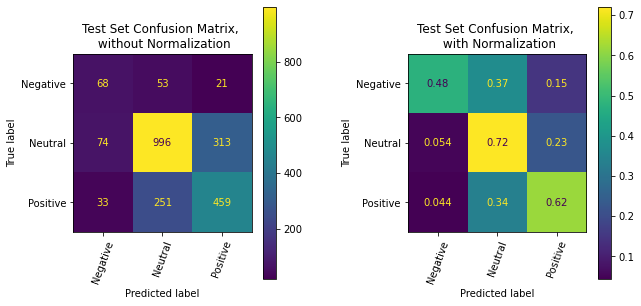

Test Accuracy: 67.15%

Cohen's Kappa Score for Test Set:
0.382

Matthew's Correlation Coefficient for Test Set:
0.382


In [9]:
confmat_and_classrep(T1LRpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test 1st tuned model

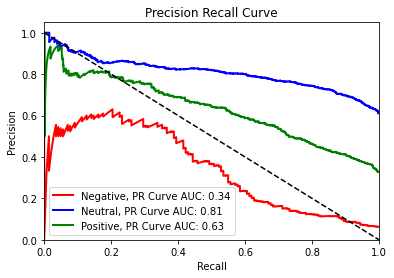

In [10]:
lb = LabelBinarizer() #Instantiating Label Binarizer
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T1LRpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each emotion

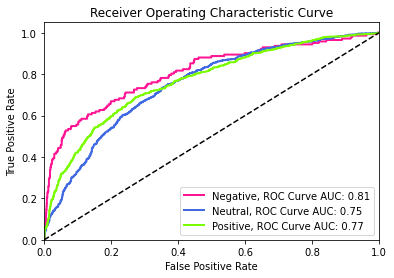

In [11]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each emotion

In [12]:
tunedscores_df.loc['6'] = pd.Series({'Model Name': 'T1LogRegCV', 'Accuracy Score': 0.67, 'Precision Score': 0.58, 
                                    'Recall Score': 0.61, 'F1 Score': 0.59, "Cohen's Kappa Score": 0.382, 
                                    "Matthew's Correlation Coefficient": 0.382, 'Neg PRC AUC Score': 0.34, 
                                    'Neu PRC AUC Score': 0.81, 'Pos PRC AUC Score': 0.63, 'Neg ROC AUC Score': 0.81, 
                                    'Neu ROC AUC Score': 0.75, 'Pos ROC AUC Score': 0.77}) #Inputting info

### Tuned Model 2: C = 1e50

In [13]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T2LRpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 1e50)), 
]) #Creating Logistic Regression pipeline with count vectorizer

T2LRpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 CountVectorizer(preprocessor=<function passthrough at 0x7fd4cb862e50>,
                                 tokenizer=<function passthrough at 0x7fd4cb862e50>)),
                ('Classifier', LogisticRegression(C=1e+50))])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.94      0.96      0.95       427
     Neutral       0.96      0.97      0.96      4148
    Positive       0.94      0.92      0.93      2227

    accuracy                           0.95      6802
   macro avg       0.95      0.95      0.95      6802
weighted avg       0.95      0.95      0.95      6802



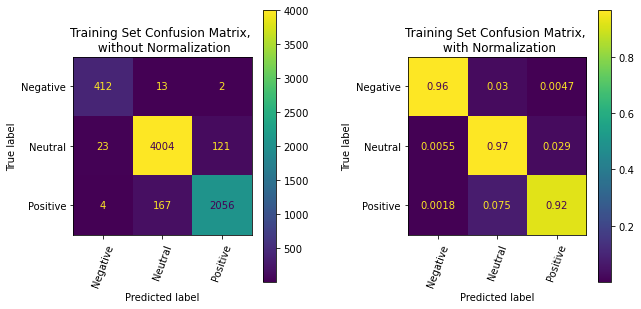

Training Accuracy: 95.15%

Cohen's Kappa Score for Training Set:
0.906

Matthew's Correlation Coefficient for Training Set:
0.906


In [14]:
confmat_and_classrep(T2LRpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR CV Model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.44      0.34      0.38       142
     Neutral       0.73      0.74      0.73      1383
    Positive       0.55      0.56      0.56       743

    accuracy                           0.65      2268
   macro avg       0.57      0.55      0.56      2268
weighted avg       0.65      0.65      0.65      2268



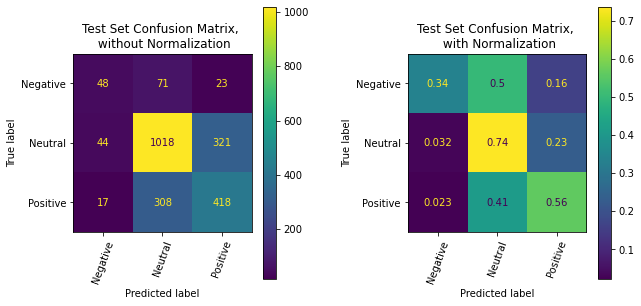

Test Accuracy: 65.43%

Cohen's Kappa Score for Test Set:
0.324

Matthew's Correlation Coefficient for Test Set:
0.324


In [15]:
confmat_and_classrep(T2LRpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test LR CV Model

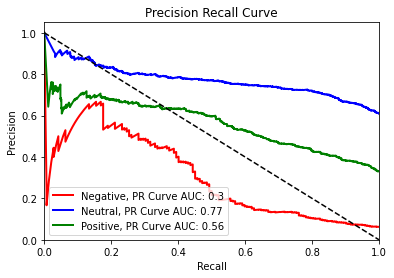

In [16]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T2LRpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each emotion

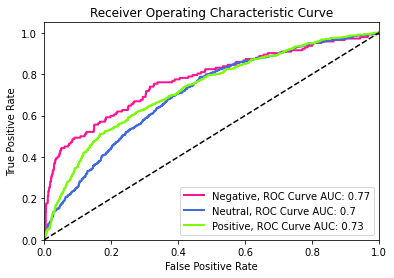

In [17]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each emotion

In [18]:
tunedscores_df.loc['7'] = pd.Series({'Model Name': 'T2LogRegCV', 'Accuracy Score': 0.65, 'Precision Score': 0.57, 
                                    'Recall Score': 0.55, 'F1 Score': 0.56, "Cohen's Kappa Score": 0.324, 
                                    "Matthew's Correlation Coefficient": 0.324, 'Neg PRC AUC Score': 0.30, 
                                    'Neu PRC AUC Score': 0.77, 'Pos PRC AUC Score': 0.56, 'Neg ROC AUC Score': 0.77, 
                                    'Neu ROC AUC Score': 0.70, 'Pos ROC AUC Score': 0.73}) #Inputting info

### Tuned Model 3: C = 0.5

In [19]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T3LRpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 0.5)), 
]) #Creating Logistic Regression pipeline with count vectorizer

T3LRpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 CountVectorizer(preprocessor=<function passthrough at 0x7fd4cb862e50>,
                                 tokenizer=<function passthrough at 0x7fd4cb862e50>)),
                ('Classifier', LogisticRegression(C=0.5))])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.97      0.65      0.78       427
     Neutral       0.87      0.96      0.91      4148
    Positive       0.91      0.78      0.84      2227

    accuracy                           0.88      6802
   macro avg       0.91      0.80      0.84      6802
weighted avg       0.89      0.88      0.88      6802



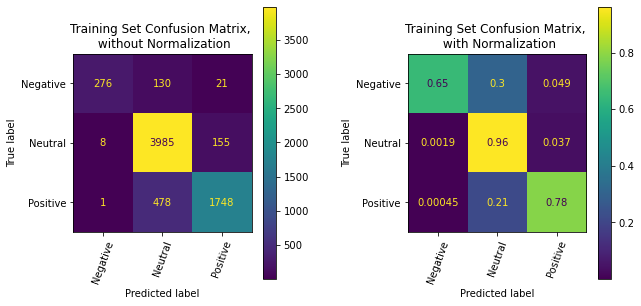

Training Accuracy: 88.34%

Cohen's Kappa Score for Training Set:
0.764

Matthew's Correlation Coefficient for Training Set:
0.77


In [20]:
confmat_and_classrep(T3LRpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR CV Model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.52      0.24      0.33       142
     Neutral       0.73      0.84      0.78      1383
    Positive       0.63      0.53      0.58       743

    accuracy                           0.70      2268
   macro avg       0.63      0.53      0.56      2268
weighted avg       0.68      0.70      0.68      2268



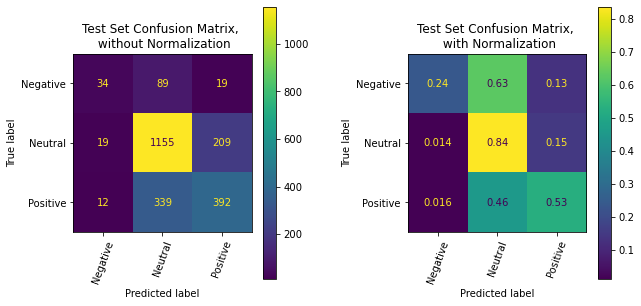

Test Accuracy: 69.71%

Cohen's Kappa Score for Test Set:
0.373

Matthew's Correlation Coefficient for Test Set:
0.379


In [21]:
confmat_and_classrep(T3LRpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test LR CV Model

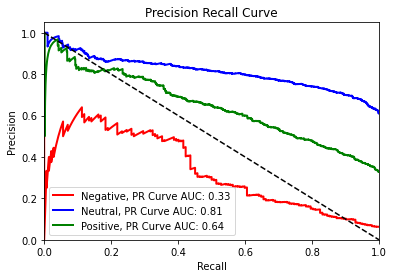

In [22]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T3LRpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each emotion

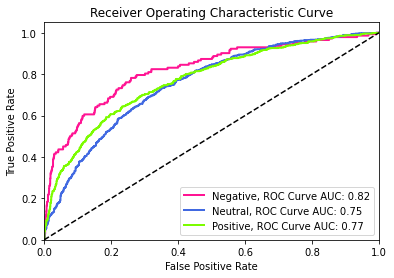

In [23]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each emotion

In [24]:
tunedscores_df.loc['8'] = pd.Series({'Model Name': 'T3LogRegCV', 'Accuracy Score': 0.70, 'Precision Score': 0.63, 
                                    'Recall Score': 0.53, 'F1 Score': 0.56, "Cohen's Kappa Score": 0.373, 
                                    "Matthew's Correlation Coefficient": 0.379, 'Neg PRC AUC Score': 0.33, 
                                    'Neu PRC AUC Score': 0.81, 'Pos PRC AUC Score': 0.64, 'Neg ROC AUC Score': 0.82, 
                                    'Neu ROC AUC Score': 0.75, 'Pos ROC AUC Score': 0.77}) #Inputting info

### Tuned Model 4: Class Weight = Balanced; C = 1e50

In [25]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T4LRpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 1e50, class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with count vectorizer

T4LRpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 CountVectorizer(preprocessor=<function passthrough at 0x7fd4cb862e50>,
                                 tokenizer=<function passthrough at 0x7fd4cb862e50>)),
                ('Classifier',
                 LogisticRegression(C=1e+50, class_weight='balanced'))])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.90      1.00      0.95       427
     Neutral       0.98      0.93      0.96      4148
    Positive       0.90      0.96      0.93      2227

    accuracy                           0.95      6802
   macro avg       0.93      0.97      0.94      6802
weighted avg       0.95      0.95      0.95      6802



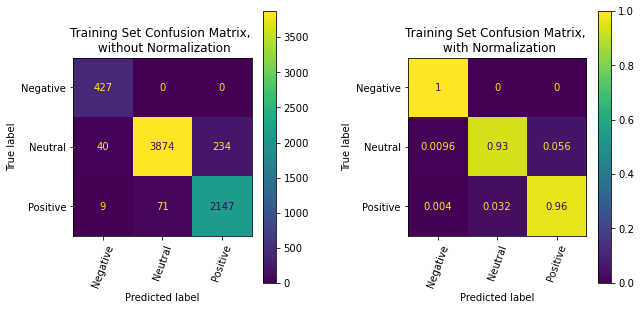

Training Accuracy: 94.80%

Cohen's Kappa Score for Training Set:
0.901

Matthew's Correlation Coefficient for Training Set:
0.903


In [26]:
confmat_and_classrep(T4LRpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR CV Model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.43      0.32      0.37       142
     Neutral       0.73      0.73      0.73      1383
    Positive       0.55      0.57      0.56       743

    accuracy                           0.65      2268
   macro avg       0.57      0.54      0.55      2268
weighted avg       0.65      0.65      0.65      2268



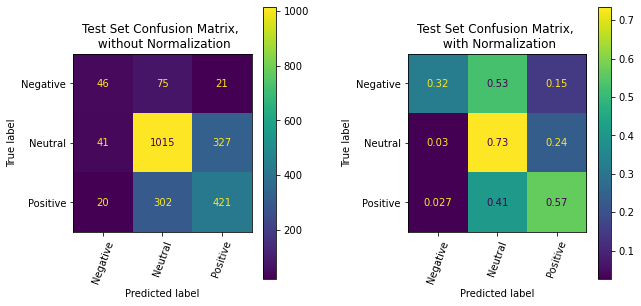

Test Accuracy: 65.34%

Cohen's Kappa Score for Test Set:
0.323

Matthew's Correlation Coefficient for Test Set:
0.323


In [27]:
confmat_and_classrep(T4LRpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test LR CV Model

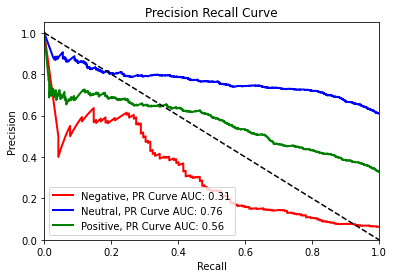

In [28]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T4LRpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each emotion

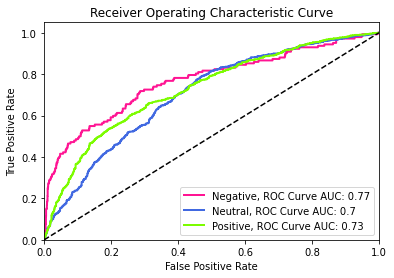

In [29]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each emotion

In [30]:
tunedscores_df.loc['9'] = pd.Series({'Model Name': 'T4LogRegCV', 'Accuracy Score': 0.65, 'Precision Score': 0.57, 
                                    'Recall Score': 0.54, 'F1 Score': 0.55, "Cohen's Kappa Score": 0.323, 
                                    "Matthew's Correlation Coefficient": 0.323, 'Neg PRC AUC Score': 0.31, 
                                    'Neu PRC AUC Score': 0.76, 'Pos PRC AUC Score': 0.56, 'Neg ROC AUC Score': 0.77, 
                                    'Neu ROC AUC Score': 0.70, 'Pos ROC AUC Score': 0.73}) #Inputting info

### Tuned Model 5: Class Weight = Balanced; C = 0.5

In [31]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T5LRpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 0.5, class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with count vectorizer

T5LRpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 CountVectorizer(preprocessor=<function passthrough at 0x7fd4cb862e50>,
                                 tokenizer=<function passthrough at 0x7fd4cb862e50>)),
                ('Classifier',
                 LogisticRegression(C=0.5, class_weight='balanced'))])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.73      1.00      0.84       427
     Neutral       0.94      0.85      0.89      4148
    Positive       0.80      0.88      0.84      2227

    accuracy                           0.87      6802
   macro avg       0.82      0.91      0.86      6802
weighted avg       0.88      0.87      0.87      6802



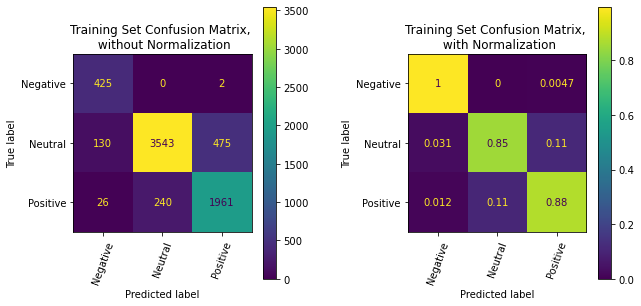

Training Accuracy: 87.17%

Cohen's Kappa Score for Training Set:
0.761

Matthew's Correlation Coefficient for Training Set:
0.765


In [32]:
confmat_and_classrep(T5LRpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR CV Model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.37      0.48      0.42       142
     Neutral       0.77      0.72      0.74      1383
    Positive       0.58      0.62      0.60       743

    accuracy                           0.67      2268
   macro avg       0.57      0.61      0.59      2268
weighted avg       0.68      0.67      0.67      2268



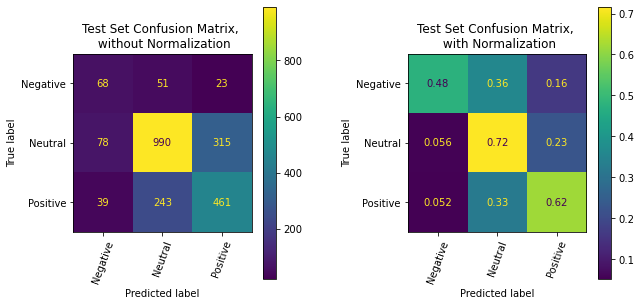

Test Accuracy: 66.98%

Cohen's Kappa Score for Test Set:
0.382

Matthew's Correlation Coefficient for Test Set:
0.383


In [33]:
confmat_and_classrep(T5LRpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test LR CV Model

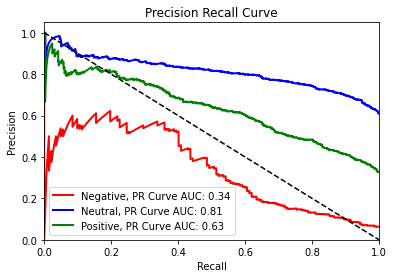

In [34]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T5LRpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each emotion

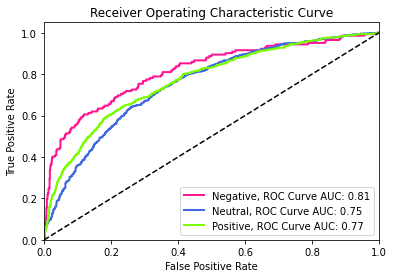

In [35]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each emotion

In [36]:
tunedscores_df.loc['10'] = pd.Series({'Model Name': 'T5LogRegCV', 'Accuracy Score': 0.67, 'Precision Score': 0.57, 
                                    'Recall Score': 0.61, 'F1 Score': 0.59, "Cohen's Kappa Score": 0.382, 
                                    "Matthew's Correlation Coefficient": 0.383, 'Neg PRC AUC Score': 0.34, 
                                    'Neu PRC AUC Score': 0.81, 'Pos PRC AUC Score': 0.63, 'Neg ROC AUC Score': 0.81, 
                                    'Neu ROC AUC Score': 0.75, 'Pos ROC AUC Score': 0.77}) #Inputting info

## Logistic Regression using TF-IDF Vectorizer

We'll be making five models here following the same protocol we used for the logistic regression models that used the count vectorizer.

### Tuned Model 6: Class Weight = Balanced

In [37]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T6LRpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with tfidf vectorizer

T6LRpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 TfidfVectorizer(preprocessor=<function passthrough at 0x7fd4cb862e50>,
                                 tokenizer=<function passthrough at 0x7fd4cb862e50>)),
                ('Classifier', LogisticRegression(class_weight='balanced'))])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.59      1.00      0.74       427
     Neutral       0.91      0.80      0.85      4148
    Positive       0.76      0.84      0.79      2227

    accuracy                           0.82      6802
   macro avg       0.76      0.88      0.80      6802
weighted avg       0.84      0.82      0.83      6802



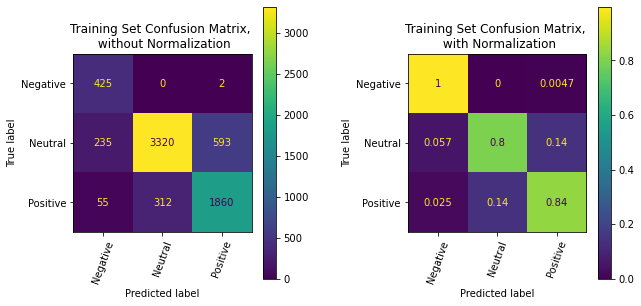

Training Accuracy: 82.40%

Cohen's Kappa Score for Training Set:
0.68

Matthew's Correlation Coefficient for Training Set:
0.686


In [38]:
confmat_and_classrep(T6LRpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR TF Model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.31      0.54      0.39       142
     Neutral       0.78      0.67      0.72      1383
    Positive       0.57      0.63      0.60       743

    accuracy                           0.65      2268
   macro avg       0.55      0.62      0.57      2268
weighted avg       0.68      0.65      0.66      2268



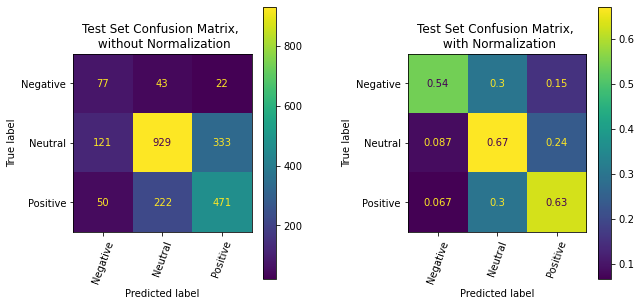

Test Accuracy: 65.12%

Cohen's Kappa Score for Test Set:
0.369

Matthew's Correlation Coefficient for Test Set:
0.373


In [39]:
confmat_and_classrep(T6LRpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test LR TF Model

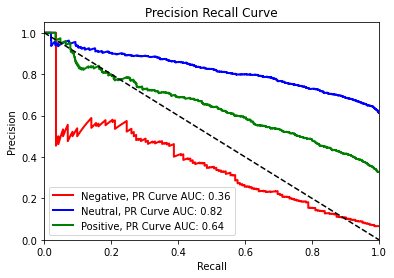

In [40]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T6LRpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each emotion

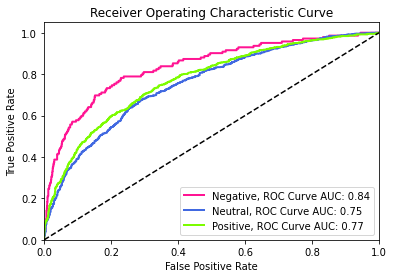

In [41]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each emotion

In [42]:
tunedscores_df.loc['11'] = pd.Series({'Model Name': 'T6LogRegTF', 'Accuracy Score': 0.65, 'Precision Score': 0.55, 
                                    'Recall Score': 0.62, 'F1 Score': 0.57, "Cohen's Kappa Score": 0.369, 
                                    "Matthew's Correlation Coefficient": 0.373, 'Neg PRC AUC Score': 0.36, 
                                    'Neu PRC AUC Score': 0.82, 'Pos PRC AUC Score': 0.64, 'Neg ROC AUC Score': 0.84, 
                                    'Neu ROC AUC Score': 0.75, 'Pos ROC AUC Score': 0.77}) #Inputting info

### Tuned Model 7: C = 1e50

In [43]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T7LRpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 1e50)), 
]) #Creating Logistic Regression pipeline with tfidf vectorizer

T7LRpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 TfidfVectorizer(preprocessor=<function passthrough at 0x7fd4cb862e50>,
                                 tokenizer=<function passthrough at 0x7fd4cb862e50>)),
                ('Classifier', LogisticRegression(C=1e+50))])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.95      0.94      0.95       427
     Neutral       0.96      0.96      0.96      4148
    Positive       0.94      0.93      0.93      2227

    accuracy                           0.95      6802
   macro avg       0.95      0.94      0.95      6802
weighted avg       0.95      0.95      0.95      6802



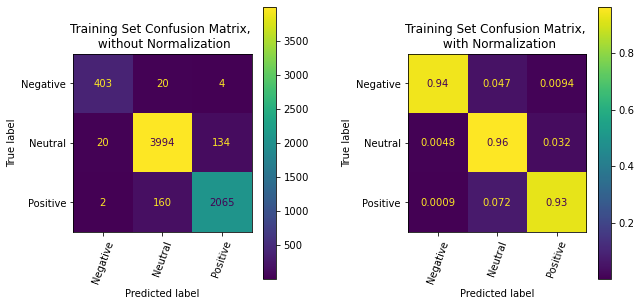

Training Accuracy: 95.00%

Cohen's Kappa Score for Training Set:
0.903

Matthew's Correlation Coefficient for Training Set:
0.903


In [44]:
confmat_and_classrep(T7LRpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR TF Model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.48      0.31      0.38       142
     Neutral       0.73      0.75      0.74      1383
    Positive       0.56      0.57      0.56       743

    accuracy                           0.66      2268
   macro avg       0.59      0.54      0.56      2268
weighted avg       0.66      0.66      0.66      2268



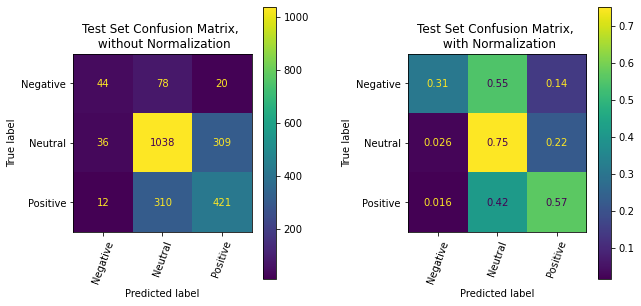

Test Accuracy: 66.27%

Cohen's Kappa Score for Test Set:
0.333

Matthew's Correlation Coefficient for Test Set:
0.333


In [45]:
confmat_and_classrep(T7LRpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test LR TF Model

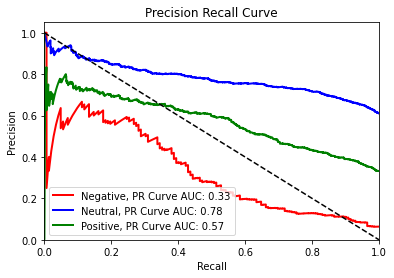

In [46]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T7LRpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each emotion

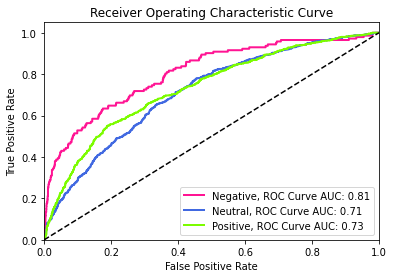

In [47]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each emotion

In [48]:
tunedscores_df.loc['12'] = pd.Series({'Model Name': 'T7LogRegTF', 'Accuracy Score': 0.66, 'Precision Score': 0.59, 
                                    'Recall Score': 0.54, 'F1 Score': 0.56, "Cohen's Kappa Score": 0.333, 
                                    "Matthew's Correlation Coefficient": 0.333, 'Neg PRC AUC Score': 0.33, 
                                    'Neu PRC AUC Score': 0.78, 'Pos PRC AUC Score': 0.57, 'Neg ROC AUC Score': 0.81, 
                                    'Neu ROC AUC Score': 0.71, 'Pos ROC AUC Score': 0.73}) #Inputting info

### Tuned Model 8: C = 0.5

In [49]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T8LRpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 0.5)), 
]) #Creating Logistic Regression pipeline with tfidf vectorizer

T8LRpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 TfidfVectorizer(preprocessor=<function passthrough at 0x7fd4cb862e50>,
                                 tokenizer=<function passthrough at 0x7fd4cb862e50>)),
                ('Classifier', LogisticRegression(C=0.5))])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.89      0.04      0.08       427
     Neutral       0.74      0.96      0.84      4148
    Positive       0.84      0.52      0.64      2227

    accuracy                           0.76      6802
   macro avg       0.82      0.51      0.52      6802
weighted avg       0.78      0.76      0.73      6802



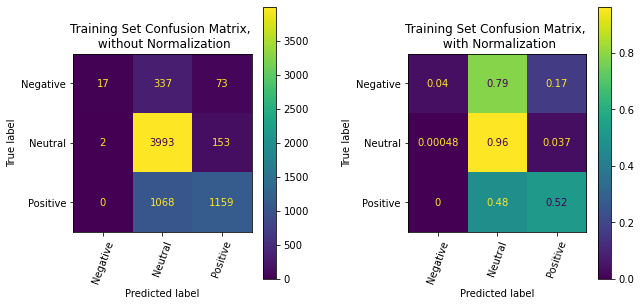

Training Accuracy: 75.99%

Cohen's Kappa Score for Training Set:
0.466

Matthew's Correlation Coefficient for Training Set:
0.507


In [50]:
confmat_and_classrep(T8LRpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR TF Model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.86      0.04      0.08       142
     Neutral       0.69      0.91      0.78      1383
    Positive       0.67      0.40      0.50       743

    accuracy                           0.69      2268
   macro avg       0.74      0.45      0.45      2268
weighted avg       0.69      0.69      0.65      2268



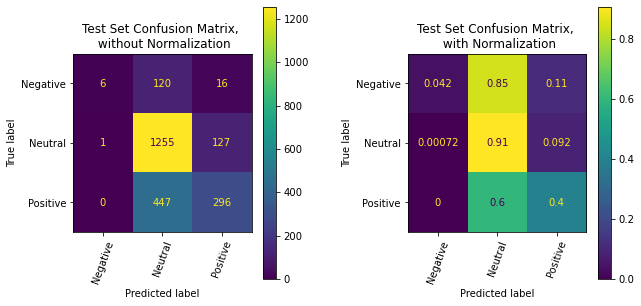

Test Accuracy: 68.65%

Cohen's Kappa Score for Test Set:
0.298

Matthew's Correlation Coefficient for Test Set:
0.329


In [51]:
confmat_and_classrep(T8LRpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test LR TF Model

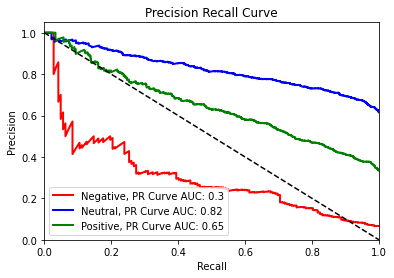

In [52]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T8LRpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each emotion

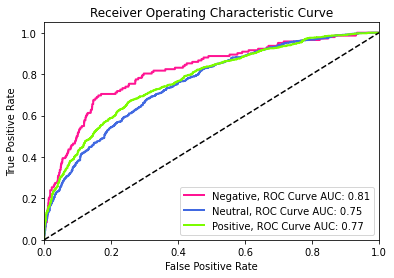

In [53]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each emotion

In [54]:
tunedscores_df.loc['13'] = pd.Series({'Model Name': 'T8LogRegTF', 'Accuracy Score': 0.69, 'Precision Score': 0.74, 
                                    'Recall Score': 0.45, 'F1 Score': 0.45, "Cohen's Kappa Score": 0.298, 
                                    "Matthew's Correlation Coefficient": 0.329, 'Neg PRC AUC Score': 0.30, 
                                    'Neu PRC AUC Score': 0.82, 'Pos PRC AUC Score': 0.65, 'Neg ROC AUC Score': 0.81, 
                                    'Neu ROC AUC Score': 0.75, 'Pos ROC AUC Score': 0.77}) #Inputting info

### Tuned Model 9: Class Weight = Balanced; C = 1e50

In [55]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T9LRpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 1e50, class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with tfidf vectorizer

T9LRpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 TfidfVectorizer(preprocessor=<function passthrough at 0x7fd4cb862e50>,
                                 tokenizer=<function passthrough at 0x7fd4cb862e50>)),
                ('Classifier',
                 LogisticRegression(C=1e+50, class_weight='balanced'))])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.90      1.00      0.95       427
     Neutral       0.99      0.93      0.96      4148
    Positive       0.90      0.97      0.94      2227

    accuracy                           0.95      6802
   macro avg       0.93      0.97      0.95      6802
weighted avg       0.95      0.95      0.95      6802



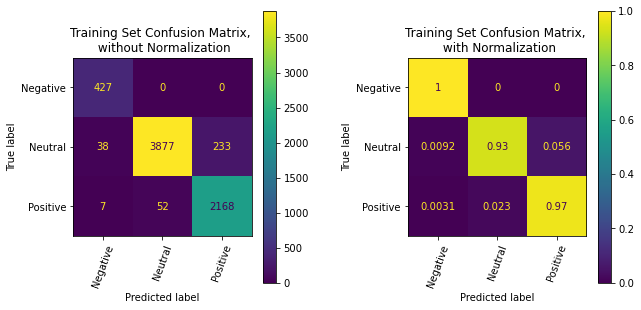

Training Accuracy: 95.15%

Cohen's Kappa Score for Training Set:
0.908

Matthew's Correlation Coefficient for Training Set:
0.91


In [56]:
confmat_and_classrep(T9LRpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR TF Model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.49      0.32      0.39       142
     Neutral       0.72      0.73      0.73      1383
    Positive       0.54      0.56      0.55       743

    accuracy                           0.65      2268
   macro avg       0.58      0.54      0.55      2268
weighted avg       0.65      0.65      0.65      2268



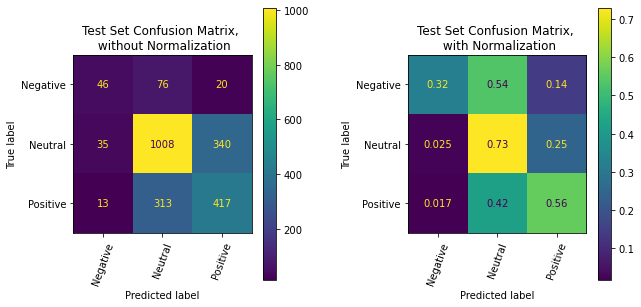

Test Accuracy: 64.86%

Cohen's Kappa Score for Test Set:
0.31

Matthew's Correlation Coefficient for Test Set:
0.311


In [57]:
confmat_and_classrep(T9LRpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test LR TF Model

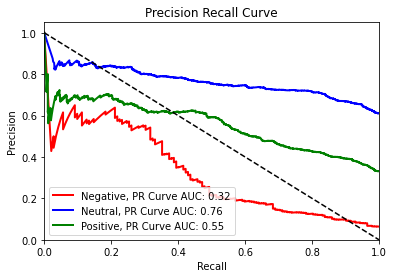

In [58]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T9LRpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each emotion

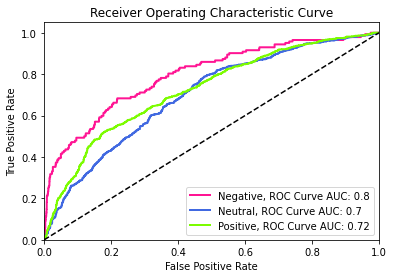

In [59]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each emotion

In [60]:
tunedscores_df.loc['14'] = pd.Series({'Model Name': 'T9LogRegTF', 'Accuracy Score': 0.65, 'Precision Score': 0.58, 
                                    'Recall Score': 0.54, 'F1 Score': 0.55, "Cohen's Kappa Score": 0.310, 
                                    "Matthew's Correlation Coefficient": 0.311, 'Neg PRC AUC Score': 0.32, 
                                    'Neu PRC AUC Score': 0.76, 'Pos PRC AUC Score': 0.55, 'Neg ROC AUC Score': 0.80, 
                                    'Neu ROC AUC Score': 0.70, 'Pos ROC AUC Score': 0.72}) #Inputting info

### Tuned Model 10: Class Weight = Balanced; C = 0.5

In [61]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T10LRpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', LogisticRegression(C = 0.5, class_weight = 'balanced')), 
]) #Creating Logistic Regression pipeline with tfidf vectorizer

T10LRpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 TfidfVectorizer(preprocessor=<function passthrough at 0x7fd4cb862e50>,
                                 tokenizer=<function passthrough at 0x7fd4cb862e50>)),
                ('Classifier',
                 LogisticRegression(C=0.5, class_weight='balanced'))])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.50      0.98      0.67       427
     Neutral       0.89      0.77      0.83      4148
    Positive       0.73      0.77      0.75      2227

    accuracy                           0.78      6802
   macro avg       0.71      0.84      0.75      6802
weighted avg       0.81      0.78      0.79      6802



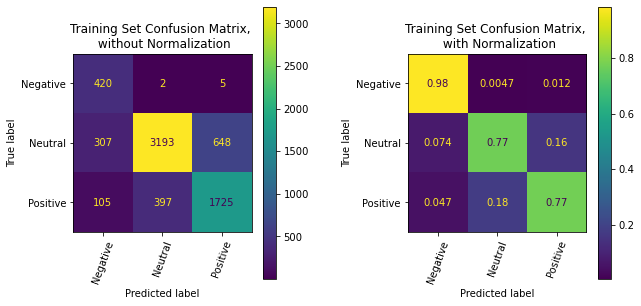

Training Accuracy: 78.48%

Cohen's Kappa Score for Training Set:
0.613

Matthew's Correlation Coefficient for Training Set:
0.62


In [62]:
confmat_and_classrep(T10LRpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #Evaluating Training LR TF Model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.29      0.61      0.39       142
     Neutral       0.79      0.66      0.71      1383
    Positive       0.57      0.63      0.60       743

    accuracy                           0.64      2268
   macro avg       0.55      0.63      0.57      2268
weighted avg       0.68      0.64      0.66      2268



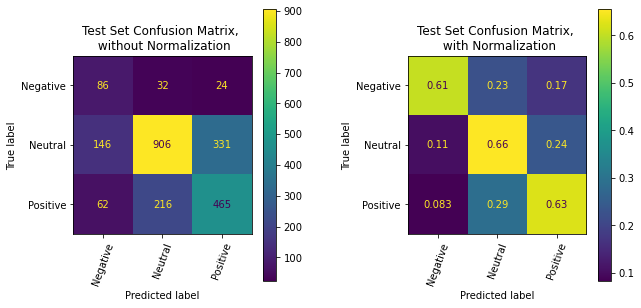

Test Accuracy: 64.24%

Cohen's Kappa Score for Test Set:
0.365

Matthew's Correlation Coefficient for Test Set:
0.371


In [63]:
confmat_and_classrep(T10LRpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #Evaluating test LR TF Model

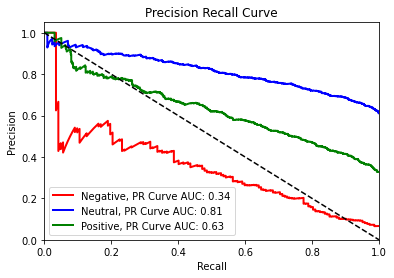

In [64]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T10LRpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each emotion

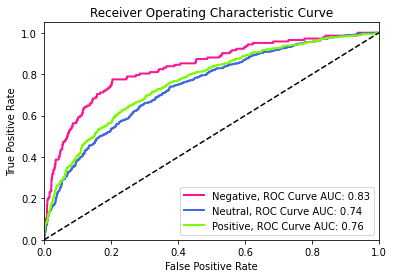

In [65]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building ROC curves for each emotion

In [66]:
tunedscores_df.loc['15'] = pd.Series({'Model Name': 'T10LogRegTF', 'Accuracy Score': 0.64, 'Precision Score': 0.55, 
                                    'Recall Score': 0.63, 'F1 Score': 0.57, "Cohen's Kappa Score": 0.365, 
                                    "Matthew's Correlation Coefficient": 0.371, 'Neg PRC AUC Score': 0.34, 
                                    'Neu PRC AUC Score': 0.81, 'Pos PRC AUC Score': 0.63, 'Neg ROC AUC Score': 0.83, 
                                    'Neu ROC AUC Score': 0.74, 'Pos ROC AUC Score': 0.76}) #Inputting info

## Random Forest using CountVectorizer

We'll be making five models here. One with class weight set to balanced, one with number of estimators set to 10, one with number of estimators set to 50, and we'll repeat those two number of estimator parameters with class weight set to balanced.

### Tuned Model 11: Class Weight = Balanced

In [67]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T11RFpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(class_weight = 'balanced')), 
]) #Creating random forest pipeline with count vectorizer

T11RFpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 CountVectorizer(preprocessor=<function passthrough at 0x7fd4cb862e50>,
                                 tokenizer=<function passthrough at 0x7fd4cb862e50>)),
                ('Classifier',
                 RandomForestClassifier(class_weight='balanced'))])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.92      1.00      0.96       427
     Neutral       0.98      0.95      0.97      4148
    Positive       0.93      0.97      0.95      2227

    accuracy                           0.96      6802
   macro avg       0.94      0.97      0.96      6802
weighted avg       0.96      0.96      0.96      6802



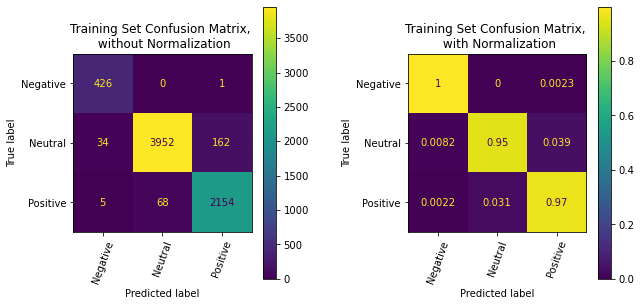

Training Accuracy: 96.03%

Cohen's Kappa Score for Training Set:
0.924

Matthew's Correlation Coefficient for Training Set:
0.925


In [68]:
confmat_and_classrep(T11RFpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #evaluating training RF CV model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.59      0.24      0.34       142
     Neutral       0.69      0.84      0.76      1383
    Positive       0.58      0.41      0.48       743

    accuracy                           0.66      2268
   macro avg       0.62      0.50      0.53      2268
weighted avg       0.65      0.66      0.64      2268



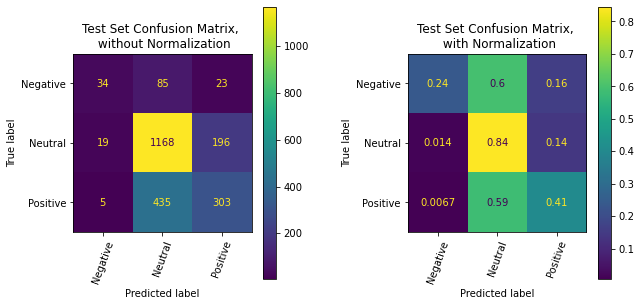

Test Accuracy: 66.36%

Cohen's Kappa Score for Test Set:
0.283

Matthew's Correlation Coefficient for Test Set:
0.295


In [69]:
confmat_and_classrep(T11RFpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #evaluating test RF CV Model

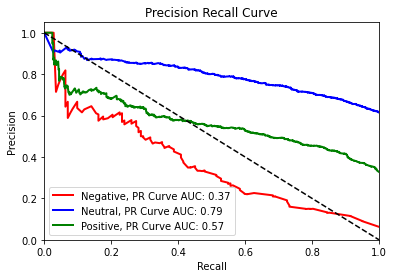

In [70]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T11RFpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each emotion

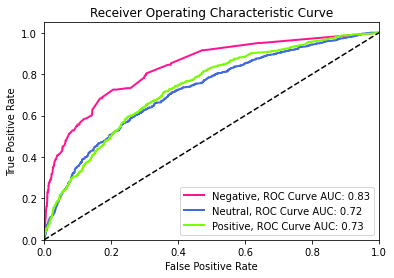

In [71]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each emotion

In [72]:
tunedscores_df.loc['16'] = pd.Series({'Model Name': 'T11RFCV', 'Accuracy Score': 0.67, 'Precision Score': 0.63, 
                                    'Recall Score': 0.50, 'F1 Score': 0.53, "Cohen's Kappa Score": 0.287, 
                                    "Matthew's Correlation Coefficient": 0.301, 'Neg PRC AUC Score': 0.38, 
                                    'Neu PRC AUC Score': 0.79, 'Pos PRC AUC Score': 0.58, 'Neg ROC AUC Score': 0.82, 
                                    'Neu ROC AUC Score': 0.72, 'Pos ROC AUC Score': 0.74}) #Inputting info

### Tuned Model 12: N_Estimators = 10

In [73]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T12RFpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(n_estimators = 10)), 
]) #Creating random forest pipeline with count vectorizer

T12RFpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 CountVectorizer(preprocessor=<function passthrough at 0x7fd4cb862e50>,
                                 tokenizer=<function passthrough at 0x7fd4cb862e50>)),
                ('Classifier', RandomForestClassifier(n_estimators=10))])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.97      0.91      0.93       427
     Neutral       0.94      0.97      0.96      4148
    Positive       0.95      0.90      0.92      2227

    accuracy                           0.94      6802
   macro avg       0.95      0.93      0.94      6802
weighted avg       0.94      0.94      0.94      6802



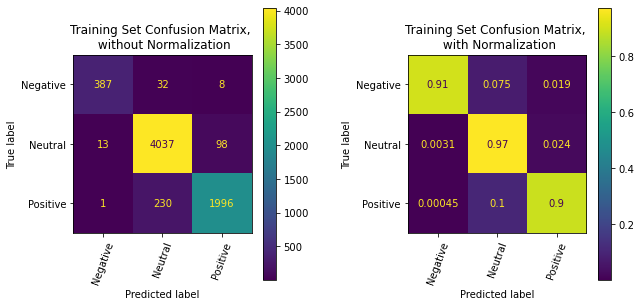

Training Accuracy: 94.38%

Cohen's Kappa Score for Training Set:
0.89

Matthew's Correlation Coefficient for Training Set:
0.891


In [74]:
confmat_and_classrep(T12RFpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #evaluating training RF CV model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.61      0.22      0.32       142
     Neutral       0.69      0.86      0.77      1383
    Positive       0.60      0.39      0.47       743

    accuracy                           0.67      2268
   macro avg       0.63      0.49      0.52      2268
weighted avg       0.65      0.67      0.64      2268



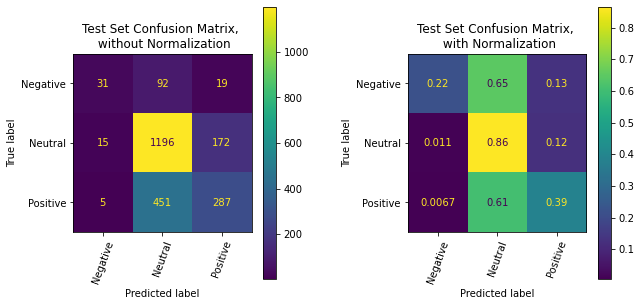

Test Accuracy: 66.75%

Cohen's Kappa Score for Test Set:
0.28

Matthew's Correlation Coefficient for Test Set:
0.297


In [75]:
confmat_and_classrep(T12RFpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #evaluating test RF CV Model

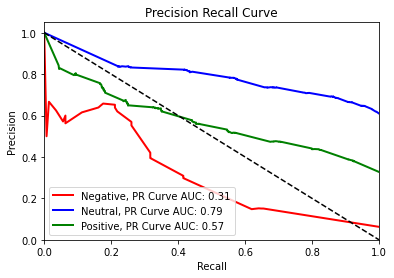

In [76]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T12RFpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each emotion

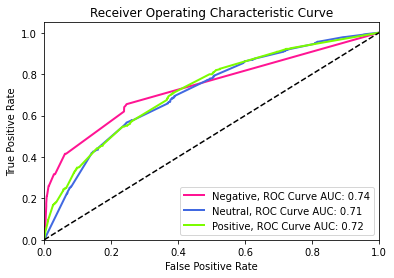

In [77]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each emotion

In [78]:
tunedscores_df.loc['17'] = pd.Series({'Model Name': 'T12RFCV', 'Accuracy Score': 0.66, 'Precision Score': 0.61, 
                                    'Recall Score': 0.49, 'F1 Score': 0.52, "Cohen's Kappa Score": 0.263, 
                                    "Matthew's Correlation Coefficient": 0.276, 'Neg PRC AUC Score': 0.31, 
                                    'Neu PRC AUC Score': 0.80, 'Pos PRC AUC Score': 0.57, 'Neg ROC AUC Score': 0.70, 
                                    'Neu ROC AUC Score': 0.72, 'Pos ROC AUC Score': 0.73}) #Inputting info

### Tuned Model 13: N_Estimators = 50

In [79]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T13RFpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(n_estimators = 50)), 
]) #Creating random forest pipeline with count vectorizer

T13RFpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 CountVectorizer(preprocessor=<function passthrough at 0x7fd4cb862e50>,
                                 tokenizer=<function passthrough at 0x7fd4cb862e50>)),
                ('Classifier', RandomForestClassifier(n_estimators=50))])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.98      0.93      0.96       427
     Neutral       0.96      0.98      0.97      4148
    Positive       0.96      0.93      0.95      2227

    accuracy                           0.96      6802
   macro avg       0.97      0.95      0.96      6802
weighted avg       0.96      0.96      0.96      6802



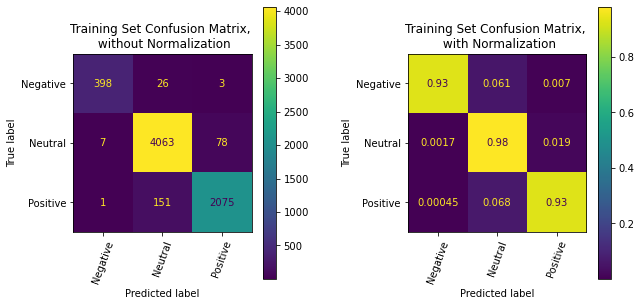

Training Accuracy: 96.09%

Cohen's Kappa Score for Training Set:
0.924

Matthew's Correlation Coefficient for Training Set:
0.924


In [80]:
confmat_and_classrep(T13RFpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #evaluating training RF CV model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.65      0.23      0.34       142
     Neutral       0.69      0.87      0.77      1383
    Positive       0.62      0.39      0.48       743

    accuracy                           0.67      2268
   macro avg       0.65      0.50      0.53      2268
weighted avg       0.66      0.67      0.65      2268



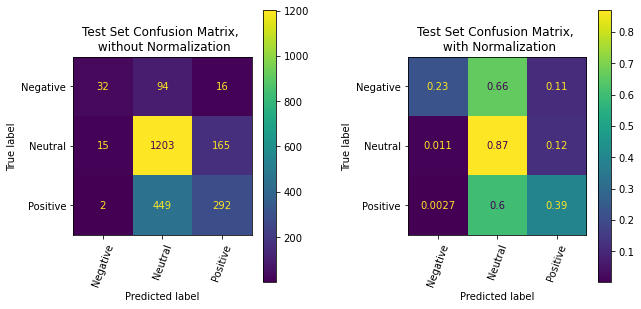

Test Accuracy: 67.33%

Cohen's Kappa Score for Test Set:
0.291

Matthew's Correlation Coefficient for Test Set:
0.31


In [81]:
confmat_and_classrep(T13RFpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #evaluating test RF CV Model

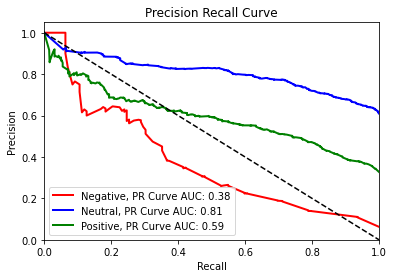

In [82]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T13RFpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each emotion

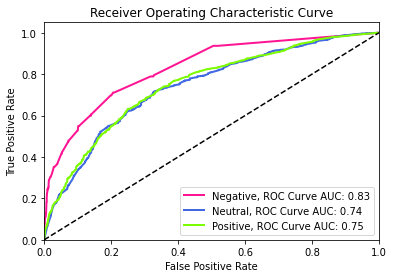

In [83]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each emotion

In [84]:
tunedscores_df.loc['18'] = pd.Series({'Model Name': 'T13RFCV', 'Accuracy Score': 0.68, 'Precision Score': 0.66, 
                                    'Recall Score': 0.50, 'F1 Score': 0.54, "Cohen's Kappa Score": 0.306, 
                                    "Matthew's Correlation Coefficient": 0.326, 'Neg PRC AUC Score': 0.37, 
                                    'Neu PRC AUC Score': 0.79, 'Pos PRC AUC Score': 0.59, 'Neg ROC AUC Score': 0.82, 
                                    'Neu ROC AUC Score': 0.73, 'Pos ROC AUC Score': 0.74}) #Inputting info

### Tuned Model 14: Class Weight = Balanced; N_Estimators = 10

In [85]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T14RFpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(n_estimators = 10, class_weight = 'balanced')), 
]) #Creating random forest pipeline with count vectorizer

T14RFpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 CountVectorizer(preprocessor=<function passthrough at 0x7fd4cb862e50>,
                                 tokenizer=<function passthrough at 0x7fd4cb862e50>)),
                ('Classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=10))])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.92      0.97      0.94       427
     Neutral       0.96      0.96      0.96      4148
    Positive       0.94      0.92      0.93      2227

    accuracy                           0.95      6802
   macro avg       0.94      0.95      0.94      6802
weighted avg       0.95      0.95      0.95      6802



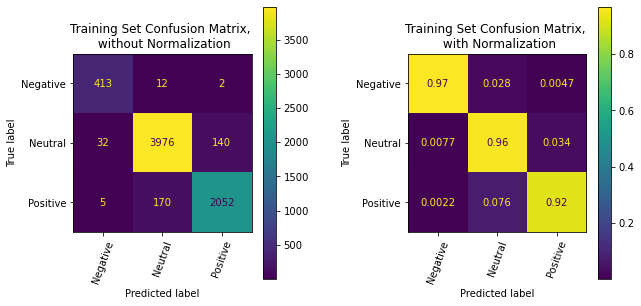

Training Accuracy: 94.69%

Cohen's Kappa Score for Training Set:
0.897

Matthew's Correlation Coefficient for Training Set:
0.897


In [86]:
confmat_and_classrep(T14RFpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #evaluating training RF CV model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.60      0.26      0.36       142
     Neutral       0.68      0.83      0.75      1383
    Positive       0.56      0.39      0.46       743

    accuracy                           0.65      2268
   macro avg       0.61      0.50      0.53      2268
weighted avg       0.64      0.65      0.63      2268



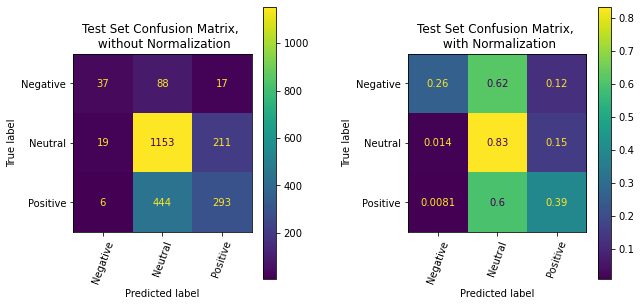

Test Accuracy: 65.39%

Cohen's Kappa Score for Test Set:
0.264

Matthew's Correlation Coefficient for Test Set:
0.274


In [87]:
confmat_and_classrep(T14RFpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #evaluating test RF CV Model

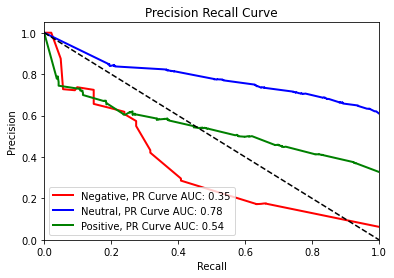

In [88]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T14RFpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each emotion

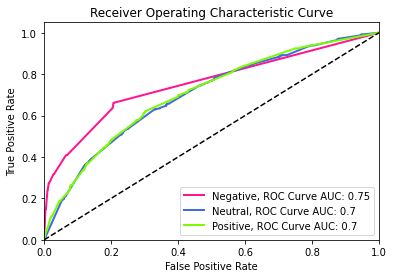

In [89]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each emotion

In [90]:
tunedscores_df.loc['19'] = pd.Series({'Model Name': 'T14RFCV', 'Accuracy Score': 0.65, 'Precision Score': 0.59, 
                                    'Recall Score': 0.48, 'F1 Score': 0.51, "Cohen's Kappa Score": 0.258, 
                                    "Matthew's Correlation Coefficient": 0.265, 'Neg PRC AUC Score': 0.28, 
                                    'Neu PRC AUC Score': 0.79, 'Pos PRC AUC Score': 0.53, 'Neg ROC AUC Score': 0.75, 
                                    'Neu ROC AUC Score': 0.70, 'Pos ROC AUC Score': 0.71}) #Inputting info

### Tuned Model 15: Class Weight = Balanced; N_Estimators = 50

In [91]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T15RFpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(n_estimators = 50, class_weight = 'balanced')), 
]) #Creating random forest pipeline with count vectorizer

T15RFpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 CountVectorizer(preprocessor=<function passthrough at 0x7fd4cb862e50>,
                                 tokenizer=<function passthrough at 0x7fd4cb862e50>)),
                ('Classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=50))])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.92      0.99      0.95       427
     Neutral       0.98      0.95      0.97      4148
    Positive       0.93      0.96      0.95      2227

    accuracy                           0.96      6802
   macro avg       0.94      0.97      0.96      6802
weighted avg       0.96      0.96      0.96      6802



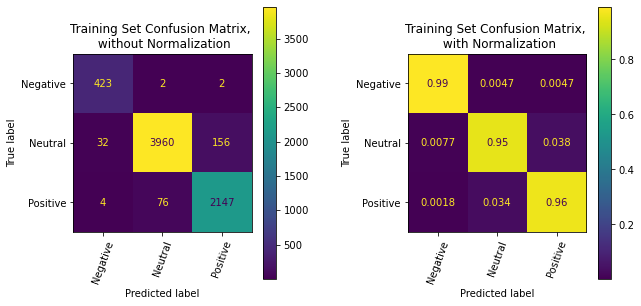

Training Accuracy: 96.00%

Cohen's Kappa Score for Training Set:
0.924

Matthew's Correlation Coefficient for Training Set:
0.924


In [92]:
confmat_and_classrep(T15RFpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #evaluating training RF CV model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.60      0.23      0.34       142
     Neutral       0.69      0.84      0.76      1383
    Positive       0.58      0.40      0.48       743

    accuracy                           0.66      2268
   macro avg       0.62      0.49      0.52      2268
weighted avg       0.65      0.66      0.64      2268



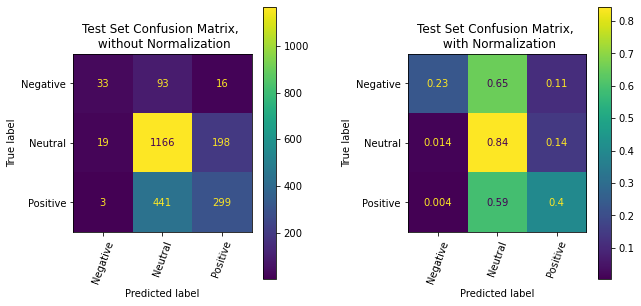

Test Accuracy: 66.05%

Cohen's Kappa Score for Test Set:
0.273

Matthew's Correlation Coefficient for Test Set:
0.286


In [93]:
confmat_and_classrep(T15RFpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #evaluating test RF CV Model

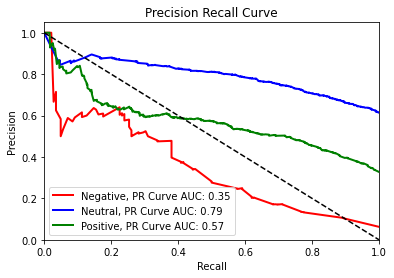

In [94]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T15RFpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each emotion

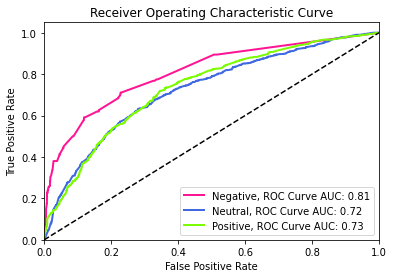

In [95]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each emotion

In [96]:
tunedscores_df.loc['20'] = pd.Series({'Model Name': 'T15RFCV', 'Accuracy Score': 0.66, 'Precision Score': 0.63, 
                                    'Recall Score': 0.49, 'F1 Score': 0.52, "Cohen's Kappa Score": 0.284, 
                                    "Matthew's Correlation Coefficient": 0.296, 'Neg PRC AUC Score': 0.37, 
                                    'Neu PRC AUC Score': 0.79, 'Pos PRC AUC Score': 0.58, 'Neg ROC AUC Score': 0.81, 
                                    'Neu ROC AUC Score': 0.73, 'Pos ROC AUC Score': 0.74}) #Inputting info

## Random Forest using TF-IDF Vectorizer

We'll be making five models here following the same protocol we used for the random forest models that used the count vectorizer.

### Tuned Model 16: Class Weight = Balanced

In [97]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T16RFpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(class_weight = 'balanced')), 
]) #Creating random forest pipeline with tfidf vectorizer

T16RFpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 TfidfVectorizer(preprocessor=<function passthrough at 0x7fd4cb862e50>,
                                 tokenizer=<function passthrough at 0x7fd4cb862e50>)),
                ('Classifier',
                 RandomForestClassifier(class_weight='balanced'))])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.92      1.00      0.96       427
     Neutral       0.98      0.95      0.97      4148
    Positive       0.93      0.97      0.95      2227

    accuracy                           0.96      6802
   macro avg       0.94      0.97      0.96      6802
weighted avg       0.96      0.96      0.96      6802



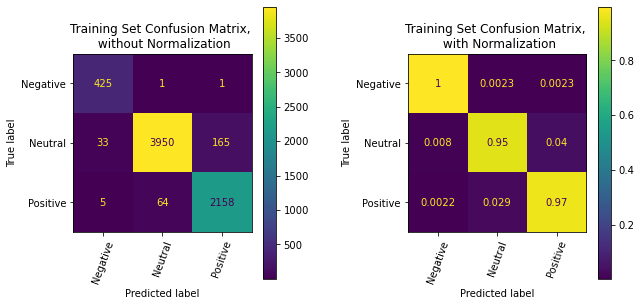

Training Accuracy: 96.05%

Cohen's Kappa Score for Training Set:
0.925

Matthew's Correlation Coefficient for Training Set:
0.925


In [98]:
confmat_and_classrep(T16RFpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #evaluating training RF TF model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.61      0.22      0.32       142
     Neutral       0.69      0.86      0.77      1383
    Positive       0.60      0.41      0.49       743

    accuracy                           0.67      2268
   macro avg       0.63      0.50      0.53      2268
weighted avg       0.66      0.67      0.65      2268



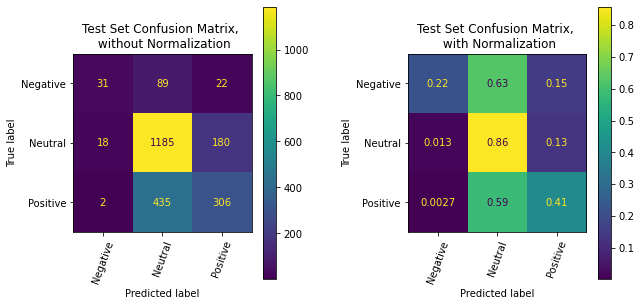

Test Accuracy: 67.11%

Cohen's Kappa Score for Test Set:
0.294

Matthew's Correlation Coefficient for Test Set:
0.308


In [99]:
confmat_and_classrep(T16RFpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #evaluating test RF TF model

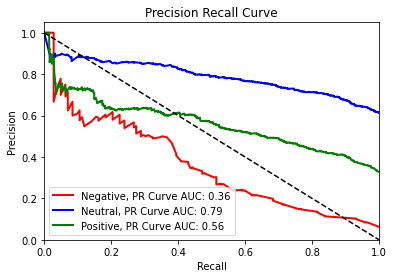

In [100]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T16RFpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #building precision recall curves for each emotion

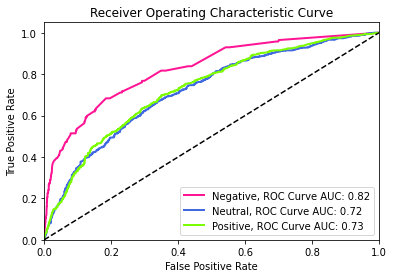

In [101]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each emotion

In [102]:
tunedscores_df.loc['21'] = pd.Series({'Model Name': 'T16RFTF', 'Accuracy Score': 0.67, 'Precision Score': 0.63, 
                                    'Recall Score': 0.49, 'F1 Score': 0.52, "Cohen's Kappa Score": 0.285, 
                                    "Matthew's Correlation Coefficient": 0.298, 'Neg PRC AUC Score': 0.37, 
                                    'Neu PRC AUC Score': 0.79, 'Pos PRC AUC Score': 0.57, 'Neg ROC AUC Score': 0.83, 
                                    'Neu ROC AUC Score': 0.72, 'Pos ROC AUC Score': 0.73}) #Inputting info

### Tuned Model 17: N_Estimators = 10

In [103]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T17RFpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(n_estimators = 10)), 
]) #Creating random forest pipeline with tfidf vectorizer

T17RFpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 TfidfVectorizer(preprocessor=<function passthrough at 0x7fd4cb862e50>,
                                 tokenizer=<function passthrough at 0x7fd4cb862e50>)),
                ('Classifier', RandomForestClassifier(n_estimators=10))])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.97      0.90      0.93       427
     Neutral       0.94      0.98      0.96      4148
    Positive       0.96      0.89      0.92      2227

    accuracy                           0.94      6802
   macro avg       0.95      0.92      0.94      6802
weighted avg       0.95      0.94      0.94      6802



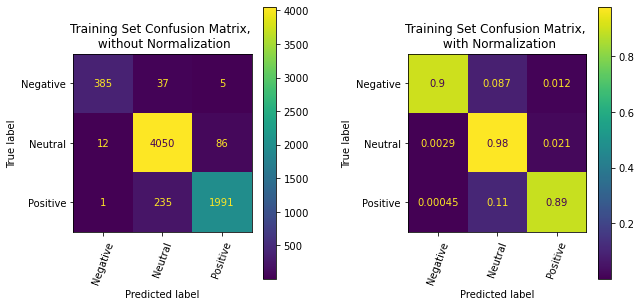

Training Accuracy: 94.47%

Cohen's Kappa Score for Training Set:
0.891

Matthew's Correlation Coefficient for Training Set:
0.892


In [104]:
confmat_and_classrep(T17RFpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #evaluating training RF TF model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.61      0.22      0.32       142
     Neutral       0.69      0.86      0.77      1383
    Positive       0.61      0.41      0.49       743

    accuracy                           0.67      2268
   macro avg       0.63      0.49      0.52      2268
weighted avg       0.66      0.67      0.65      2268



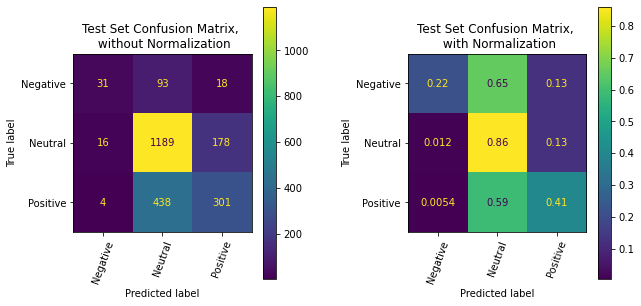

Test Accuracy: 67.06%

Cohen's Kappa Score for Test Set:
0.291

Matthew's Correlation Coefficient for Test Set:
0.306


In [105]:
confmat_and_classrep(T17RFpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #evaluating test RF TF model

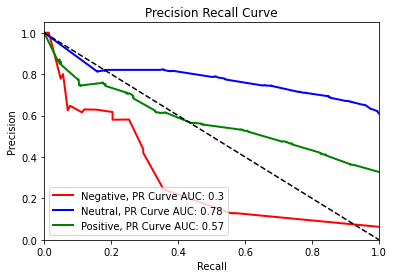

In [106]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T17RFpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #building precision recall curves for each emotion

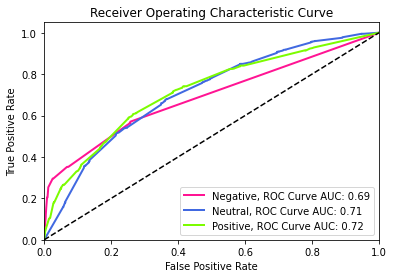

In [107]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each emotion

In [108]:
tunedscores_df.loc['22'] = pd.Series({'Model Name': 'T17RFTF', 'Accuracy Score': 0.67, 'Precision Score': 0.61, 
                                    'Recall Score': 0.49, 'F1 Score': 0.52, "Cohen's Kappa Score": 0.286, 
                                    "Matthew's Correlation Coefficient": 0.299, 'Neg PRC AUC Score': 0.31, 
                                    'Neu PRC AUC Score': 0.78, 'Pos PRC AUC Score': 0.56, 'Neg ROC AUC Score': 0.71, 
                                    'Neu ROC AUC Score': 0.71, 'Pos ROC AUC Score': 0.72}) #Inputting info

### Tuned Model 18: N_Estimators = 50

In [109]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T18RFpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(n_estimators = 50)), 
]) #Creating random forest pipeline with tfidf vectorizer

T18RFpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 TfidfVectorizer(preprocessor=<function passthrough at 0x7fd4cb862e50>,
                                 tokenizer=<function passthrough at 0x7fd4cb862e50>)),
                ('Classifier', RandomForestClassifier(n_estimators=50))])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.98      0.93      0.96       427
     Neutral       0.96      0.98      0.97      4148
    Positive       0.97      0.93      0.95      2227

    accuracy                           0.96      6802
   macro avg       0.97      0.95      0.96      6802
weighted avg       0.96      0.96      0.96      6802



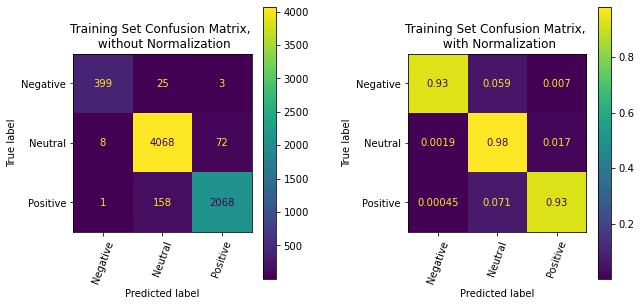

Training Accuracy: 96.07%

Cohen's Kappa Score for Training Set:
0.923

Matthew's Correlation Coefficient for Training Set:
0.924


In [110]:
confmat_and_classrep(T18RFpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #evaluating training RF TF model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.64      0.20      0.31       142
     Neutral       0.69      0.87      0.77      1383
    Positive       0.63      0.41      0.50       743

    accuracy                           0.68      2268
   macro avg       0.66      0.49      0.53      2268
weighted avg       0.67      0.68      0.65      2268



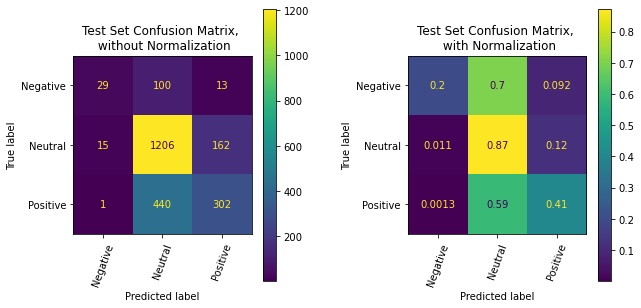

Test Accuracy: 67.77%

Cohen's Kappa Score for Test Set:
0.3

Matthew's Correlation Coefficient for Test Set:
0.319


In [111]:
confmat_and_classrep(T18RFpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #evaluating test RF TF model

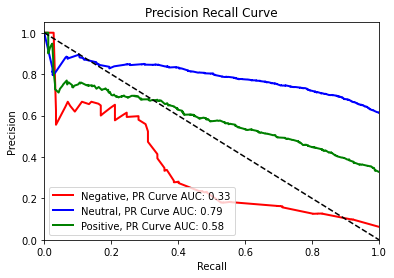

In [112]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T18RFpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #building precision recall curves for each emotion

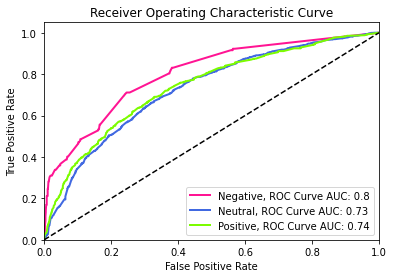

In [113]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each emotion

In [114]:
tunedscores_df.loc['23'] = pd.Series({'Model Name': 'T18RFTF', 'Accuracy Score': 0.67, 'Precision Score': 0.65, 
                                    'Recall Score': 0.49, 'F1 Score': 0.52, "Cohen's Kappa Score": 0.284, 
                                    "Matthew's Correlation Coefficient": 0.304, 'Neg PRC AUC Score': 0.33, 
                                    'Neu PRC AUC Score': 0.79, 'Pos PRC AUC Score': 0.58, 'Neg ROC AUC Score': 0.77, 
                                    'Neu ROC AUC Score': 0.72, 'Pos ROC AUC Score': 0.74}) #Inputting info

### Tuned Model 19: Class Weight = Balanced; N_Estimators = 10

In [115]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T19RFpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(n_estimators = 10, class_weight = 'balanced')), 
]) #Creating random forest pipeline with tfidf vectorizer

T19RFpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 TfidfVectorizer(preprocessor=<function passthrough at 0x7fd4cb862e50>,
                                 tokenizer=<function passthrough at 0x7fd4cb862e50>)),
                ('Classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=10))])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.93      0.95      0.94       427
     Neutral       0.96      0.96      0.96      4148
    Positive       0.93      0.93      0.93      2227

    accuracy                           0.95      6802
   macro avg       0.94      0.95      0.94      6802
weighted avg       0.95      0.95      0.95      6802



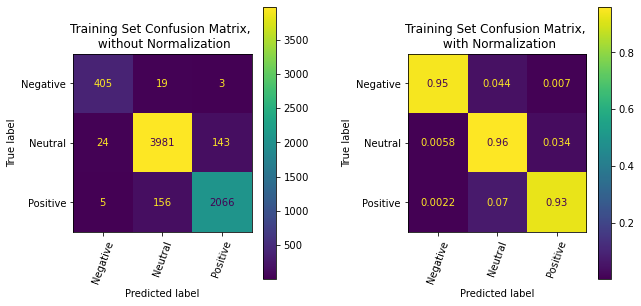

Training Accuracy: 94.85%

Cohen's Kappa Score for Training Set:
0.9

Matthew's Correlation Coefficient for Training Set:
0.9


In [116]:
confmat_and_classrep(T19RFpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #evaluating training RF TF model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.48      0.20      0.28       142
     Neutral       0.68      0.83      0.75      1383
    Positive       0.55      0.40      0.46       743

    accuracy                           0.65      2268
   macro avg       0.57      0.47      0.50      2268
weighted avg       0.63      0.65      0.62      2268



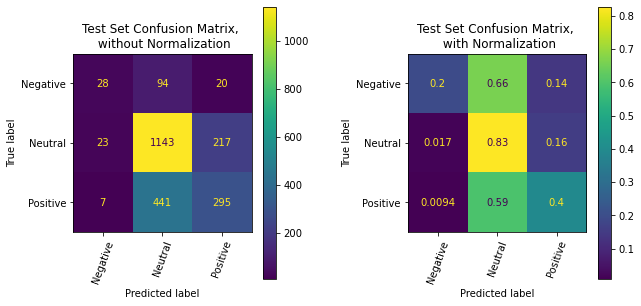

Test Accuracy: 64.64%

Cohen's Kappa Score for Test Set:
0.248

Matthew's Correlation Coefficient for Test Set:
0.258


In [117]:
confmat_and_classrep(T19RFpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #evaluating test RF TF model

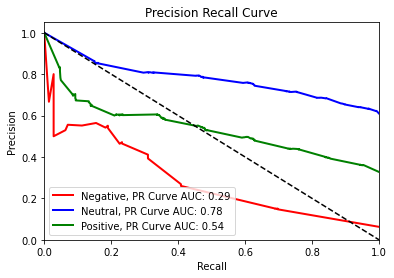

In [118]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T19RFpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #building precision recall curves for each emotion

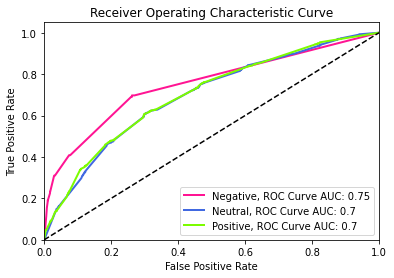

In [119]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each emotion

In [120]:
tunedscores_df.loc['24'] = pd.Series({'Model Name': 'T19RFTF', 'Accuracy Score': 0.64, 'Precision Score': 0.60, 
                                    'Recall Score': 0.48, 'F1 Score': 0.50, "Cohen's Kappa Score": 0.232, 
                                    "Matthew's Correlation Coefficient": 0.244, 'Neg PRC AUC Score': 0.31, 
                                    'Neu PRC AUC Score': 0.78, 'Pos PRC AUC Score': 0.54, 'Neg ROC AUC Score': 0.73, 
                                    'Neu ROC AUC Score': 0.69, 'Pos ROC AUC Score': 0.70}) #Inputting info

### Tuned Model 20: Class Weight = Balanced; N_Estimators = 50

In [121]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T20RFpipelineTF = Pipeline([
    ('BOW', TfidfVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', RandomForestClassifier(n_estimators = 50, class_weight = 'balanced')), 
]) #Creating random forest pipeline with tfidf vectorizer

T20RFpipelineTF.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 TfidfVectorizer(preprocessor=<function passthrough at 0x7fd4cb862e50>,
                                 tokenizer=<function passthrough at 0x7fd4cb862e50>)),
                ('Classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=50))])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.91      1.00      0.95       427
     Neutral       0.98      0.96      0.97      4148
    Positive       0.94      0.96      0.95      2227

    accuracy                           0.96      6802
   macro avg       0.94      0.97      0.96      6802
weighted avg       0.96      0.96      0.96      6802



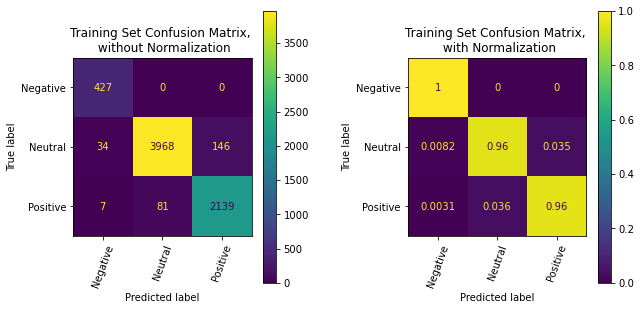

Training Accuracy: 96.06%

Cohen's Kappa Score for Training Set:
0.925

Matthew's Correlation Coefficient for Training Set:
0.925


In [122]:
confmat_and_classrep(T20RFpipelineTF, X_train, y_train_enc, le.classes_, 'Training') #evaluating training RF TF model

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.58      0.20      0.30       142
     Neutral       0.69      0.84      0.75      1383
    Positive       0.56      0.40      0.47       743

    accuracy                           0.65      2268
   macro avg       0.61      0.48      0.51      2268
weighted avg       0.64      0.65      0.63      2268



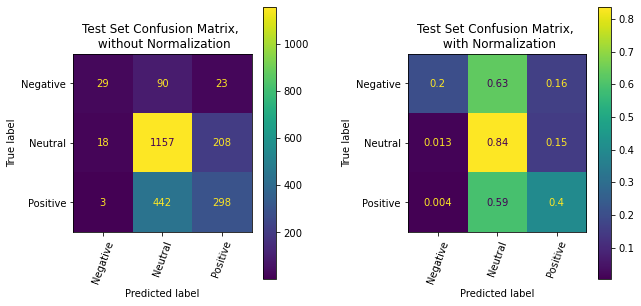

Test Accuracy: 65.43%

Cohen's Kappa Score for Test Set:
0.262

Matthew's Correlation Coefficient for Test Set:
0.272


In [123]:
confmat_and_classrep(T20RFpipelineTF, X_test, y_test_enc, le.classes_, 'Test') #evaluating test RF TF model

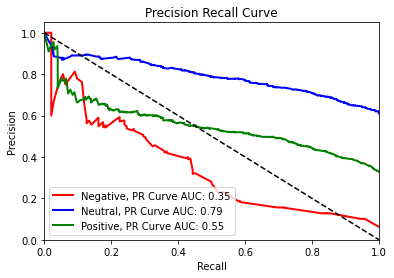

In [124]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T20RFpipelineTF.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #building precision recall curves for each emotion

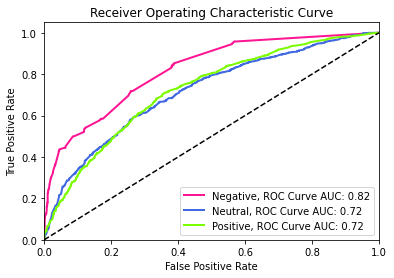

In [125]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each emotion

In [126]:
tunedscores_df.loc['25'] = pd.Series({'Model Name': 'T20RFTF', 'Accuracy Score': 0.66, 'Precision Score': 0.62, 
                                    'Recall Score': 0.48, 'F1 Score': 0.51, "Cohen's Kappa Score": 0.274, 
                                    "Matthew's Correlation Coefficient": 0.288, 'Neg PRC AUC Score': 0.34, 
                                    'Neu PRC AUC Score': 0.78, 'Pos PRC AUC Score': 0.56, 'Neg ROC AUC Score': 0.81, 
                                    'Neu ROC AUC Score': 0.71, 'Pos ROC AUC Score': 0.72}) #Inputting info

## Multinomial Naive Bayes using CountVectorizer

We'll be making three models here. One with alpha set to 0.001, one with alpha set to 0.01, and one with alpha set to 0.1.

### Tuned Model 21: Alpha = 0.001

In [127]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T21MNBpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', MultinomialNB(alpha = 0.001)), 
]) #Creating multinomial naive bayes pipeline with count vectorizer

T21MNBpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 CountVectorizer(preprocessor=<function passthrough at 0x7fd4cb862e50>,
                                 tokenizer=<function passthrough at 0x7fd4cb862e50>)),
                ('Classifier', MultinomialNB(alpha=0.001))])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.81      0.92      0.86       427
     Neutral       0.92      0.88      0.90      4148
    Positive       0.82      0.86      0.84      2227

    accuracy                           0.88      6802
   macro avg       0.85      0.89      0.87      6802
weighted avg       0.88      0.88      0.88      6802



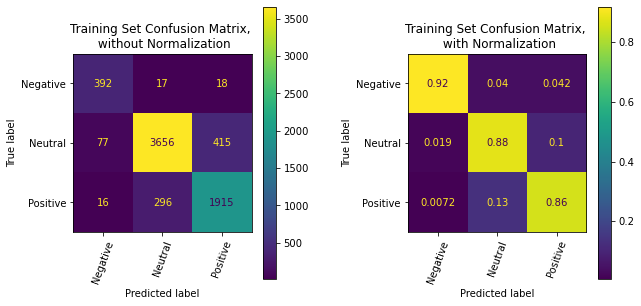

Training Accuracy: 87.67%

Cohen's Kappa Score for Training Set:
0.766

Matthew's Correlation Coefficient for Training Set:
0.767


In [128]:
confmat_and_classrep(T21MNBpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #evaluating training MNB CV

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.44      0.34      0.38       142
     Neutral       0.74      0.72      0.73      1383
    Positive       0.54      0.59      0.56       743

    accuracy                           0.65      2268
   macro avg       0.57      0.55      0.56      2268
weighted avg       0.66      0.65      0.65      2268



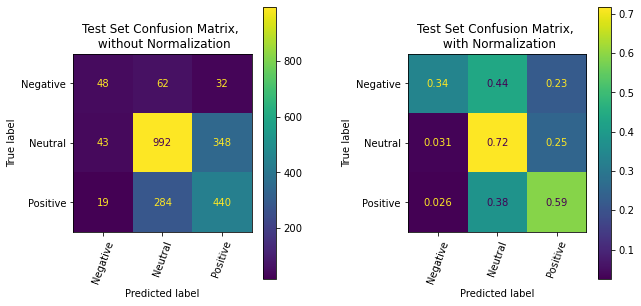

Test Accuracy: 65.26%

Cohen's Kappa Score for Test Set:
0.33

Matthew's Correlation Coefficient for Test Set:
0.331


In [129]:
confmat_and_classrep(T21MNBpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #evaluating test MNB CV Model

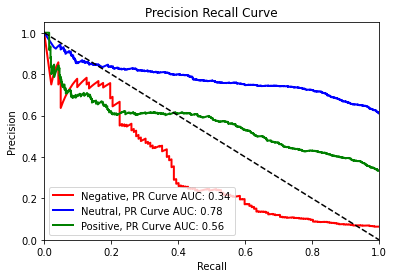

In [130]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T21MNBpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each emotion

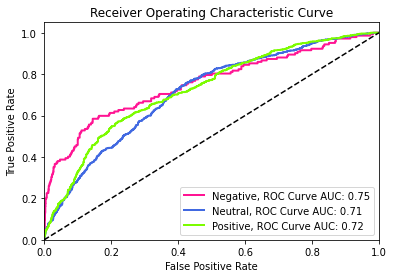

In [131]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each emotion

In [132]:
tunedscores_df.loc['26'] = pd.Series({'Model Name': 'T21MNBCV', 'Accuracy Score': 0.65, 'Precision Score': 0.57, 
                                    'Recall Score': 0.55, 'F1 Score': 0.56, "Cohen's Kappa Score": 0.330, 
                                    "Matthew's Correlation Coefficient": 0.331, 'Neg PRC AUC Score': 0.34, 
                                    'Neu PRC AUC Score': 0.78, 'Pos PRC AUC Score': 0.56, 'Neg ROC AUC Score': 0.75, 
                                    'Neu ROC AUC Score': 0.71, 'Pos ROC AUC Score': 0.72}) #Inputting info

### Tuned Model 22: Alpha = 0.01

In [133]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T22MNBpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', MultinomialNB(alpha = 0.01)), 
]) #Creating multinomial naive bayes pipeline with count vectorizer

T22MNBpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 CountVectorizer(preprocessor=<function passthrough at 0x7fd4cb862e50>,
                                 tokenizer=<function passthrough at 0x7fd4cb862e50>)),
                ('Classifier', MultinomialNB(alpha=0.01))])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.78      0.91      0.84       427
     Neutral       0.92      0.88      0.90      4148
    Positive       0.81      0.86      0.83      2227

    accuracy                           0.87      6802
   macro avg       0.84      0.88      0.86      6802
weighted avg       0.88      0.87      0.87      6802



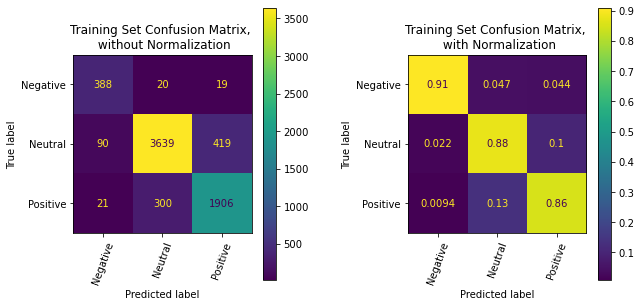

Training Accuracy: 87.22%

Cohen's Kappa Score for Training Set:
0.758

Matthew's Correlation Coefficient for Training Set:
0.759


In [134]:
confmat_and_classrep(T22MNBpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #evaluating training MNB CV 

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.40      0.36      0.38       142
     Neutral       0.75      0.71      0.73      1383
    Positive       0.54      0.59      0.57       743

    accuracy                           0.65      2268
   macro avg       0.56      0.56      0.56      2268
weighted avg       0.66      0.65      0.65      2268



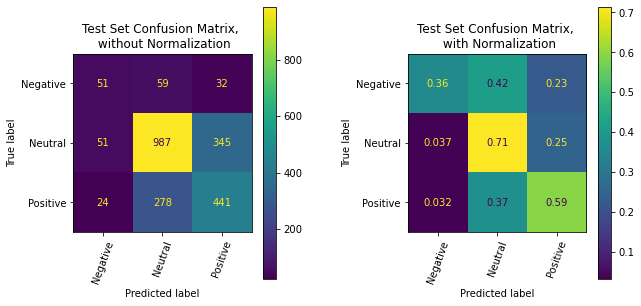

Test Accuracy: 65.21%

Cohen's Kappa Score for Test Set:
0.334

Matthew's Correlation Coefficient for Test Set:
0.335


In [135]:
confmat_and_classrep(T22MNBpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #evaluating test MNB CV Model

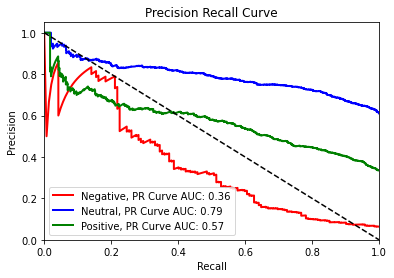

In [136]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T22MNBpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each emotion

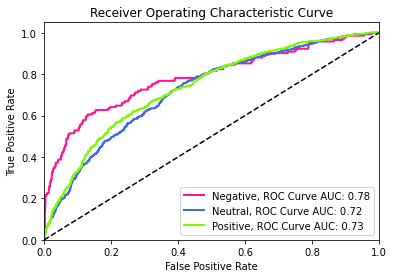

In [137]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each emotion

In [138]:
tunedscores_df.loc['27'] = pd.Series({'Model Name': 'T22MNBCV', 'Accuracy Score': 0.65, 'Precision Score': 0.56, 
                                    'Recall Score': 0.56, 'F1 Score': 0.56, "Cohen's Kappa Score": 0.334, 
                                    "Matthew's Correlation Coefficient": 0.335, 'Neg PRC AUC Score': 0.36, 
                                    'Neu PRC AUC Score': 0.79, 'Pos PRC AUC Score': 0.57, 'Neg ROC AUC Score': 0.78, 
                                    'Neu ROC AUC Score': 0.72, 'Pos ROC AUC Score': 0.73}) #Inputting info

### Tuned Model 23: Alpha = 0.1

In [139]:
y_train_enc = le.fit_transform(y_train) #fitting y_train
y_test_enc = le.transform(y_test) #transforming y_test

T23MNBpipelineCV = Pipeline([
    ('BOW', CountVectorizer(preprocessor = passthrough, tokenizer = passthrough)), 
    ('Classifier', MultinomialNB(alpha = 0.1)), 
]) #Creating multinomial naive bayes pipeline with count vectorizer

T23MNBpipelineCV.fit(X_train, y_train_enc) #Fitting to pipeline

Pipeline(steps=[('BOW',
                 CountVectorizer(preprocessor=<function passthrough at 0x7fd4cb862e50>,
                                 tokenizer=<function passthrough at 0x7fd4cb862e50>)),
                ('Classifier', MultinomialNB(alpha=0.1))])

Classification Report for Training Set
              precision    recall  f1-score   support

    Negative       0.72      0.88      0.79       427
     Neutral       0.91      0.87      0.89      4148
    Positive       0.81      0.85      0.83      2227

    accuracy                           0.86      6802
   macro avg       0.81      0.86      0.84      6802
weighted avg       0.87      0.86      0.86      6802



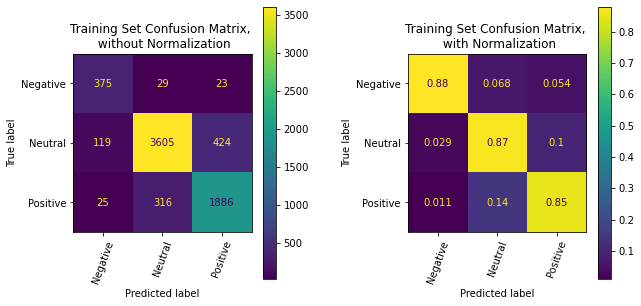

Training Accuracy: 86.24%

Cohen's Kappa Score for Training Set:
0.74

Matthew's Correlation Coefficient for Training Set:
0.741


In [140]:
confmat_and_classrep(T23MNBpipelineCV, X_train, y_train_enc, le.classes_, 'Training') #evaluating training MNB CV 

Classification Report for Test Set
              precision    recall  f1-score   support

    Negative       0.38      0.35      0.36       142
     Neutral       0.75      0.72      0.74      1383
    Positive       0.55      0.60      0.57       743

    accuracy                           0.66      2268
   macro avg       0.56      0.56      0.56      2268
weighted avg       0.66      0.66      0.66      2268



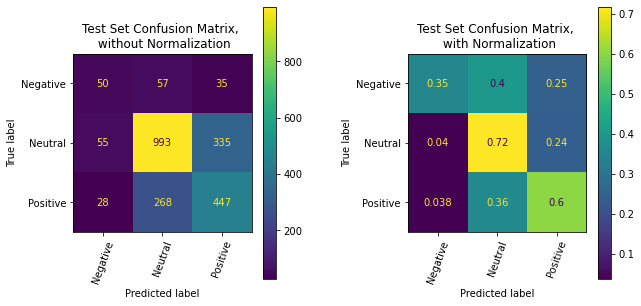

Test Accuracy: 65.70%

Cohen's Kappa Score for Test Set:
0.345

Matthew's Correlation Coefficient for Test Set:
0.346


In [141]:
confmat_and_classrep(T23MNBpipelineCV, X_test, y_test_enc, le.classes_, 'Test') #evaluating test MNB CV Model

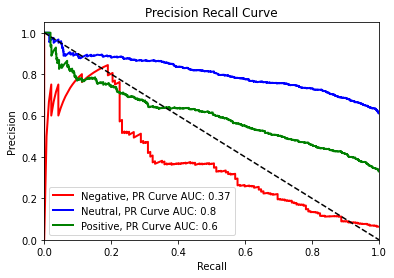

In [142]:
lb.fit(y_test_enc) #fitting y_test_enc
y_test_multi = lb.transform(y_test_enc) #setting y_test_multi to transformed encoded y test
y_hat_test_multi = T23MNBpipelineCV.predict_proba(X_test) #setting multi y hat test to predict

pr_curves(y_test_multi, y_hat_test_multi, le.classes_) #Building precision recall curves for each emotion

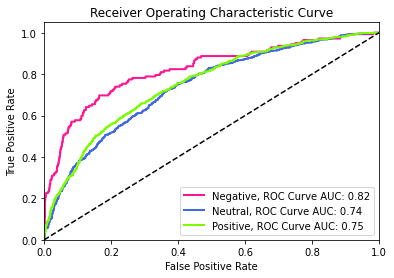

In [143]:
roc_curves(y_test_multi, y_hat_test_multi, le.classes_) #building roc curves for each emotion

In [144]:
tunedscores_df.loc['28'] = pd.Series({'Model Name': 'T23MNBCV', 'Accuracy Score': 0.66, 'Precision Score': 0.56, 
                                    'Recall Score': 0.56, 'F1 Score': 0.56, "Cohen's Kappa Score": 0.345, 
                                    "Matthew's Correlation Coefficient": 0.346, 'Neg PRC AUC Score': 0.37, 
                                    'Neu PRC AUC Score': 0.80, 'Pos PRC AUC Score': 0.60, 'Neg ROC AUC Score': 0.82, 
                                    'Neu ROC AUC Score': 0.74, 'Pos ROC AUC Score': 0.75}) #Inputting info

# Comparing Tuned Models

Now that we've tuned all our models, let's take a look at our tuned model scores df and again sort it by Cohen's Kappa score and see how these tuned models performed.

In [145]:
tunedscores_df.sort_values(by = ["Cohen's Kappa Score"], ascending = False) #Comparing tuned models

,Model Name,Accuracy Score,Precision Score,Recall Score,F1 Score,Cohen's Kappa Score,Matthew's Correlation Coefficient,Neg PRC AUC Score,Neu PRC AUC Score,Pos PRC AUC Score,Neg ROC AUC Score,Neu ROC AUC Score,Pos ROC AUC Score
6,T1LogRegCV,0.67,0.58,0.61,0.59,0.382,0.382,0.34,0.81,0.63,0.81,0.75,0.77
10,T5LogRegCV,0.67,0.57,0.61,0.59,0.382,0.383,0.34,0.81,0.63,0.81,0.75,0.77
1,LogRegCV,0.69,0.63,0.55,0.58,0.373,0.377,0.34,0.81,0.63,0.82,0.75,0.77
8,T3LogRegCV,0.7,0.63,0.53,0.56,0.373,0.379,0.33,0.81,0.64,0.82,0.75,0.77
11,T6LogRegTF,0.65,0.55,0.62,0.57,0.369,0.373,0.36,0.82,0.64,0.84,0.75,0.77
15,T10LogRegTF,0.64,0.55,0.63,0.57,0.365,0.371,0.34,0.81,0.63,0.83,0.74,0.76
28,T23MNBCV,0.66,0.56,0.56,0.56,0.345,0.346,0.37,0.8,0.6,0.82,0.74,0.75
2,MNBCV,0.68,0.66,0.51,0.54,0.342,0.345,0.31,0.8,0.62,0.78,0.74,0.75
3,LogRegTF,0.7,0.64,0.47,0.49,0.341,0.359,0.33,0.82,0.66,0.83,0.76,0.77
27,T22MNBCV,0.65,0.56,0.56,0.56,0.334,0.335,0.36,0.79,0.57,0.78,0.72,0.73


It appears as though our top performing model was our first tuned model: Logistic Regression using CountVectorizer with class weight set to balanced. Our fifth tuned model is actually just about the same in almost all aspects, the only score differences are precision (a 0.01 difference) and Matthew's Correlation Coefficient (a 0.001 difference). That model was a Logistic Regression using CountVectorizer with class weight set to balanced and C = 0.5.


# Conclusions

The purpose of this project was to build a model that can rate the sentiment of a tweet based on it's content. For this project, we only created a multiclass classifier. After thorough preprocessing, exploratory data analysis, and baseline modeling, we tuned 23 models to determine our best and final model. Based on the models we created, we were able to do so with general success using a Logistic Regression model with Count Vectorizer and class weight equal to balanced, yielding an accuracy of 67.15%.

Our EDA provided us with a lot of information about this dataset, specifically that a majority of the sentiment surrounding the tweets was rated as neutral, so when going through the modeling process it makes sense that precision recall curves and roc curves for that class are the highest in every case. Although most of the tweets are about neutral content, looking deeper into negative and positive tweets will certainly provide more feedback to stakeholders. A majority of tweets about the brand apple were negative, and that is something that they should look into regarding the SXSW festival. In addition, the most common phrases that were seen among all sentiments were the same; they were generally about pop ups or products around the festival.

Hashtags were very popular among all sentiments and brands, specifically the hashtag #SXSW, which was prevalent among all sentiments and brands. In addition, negative tweets had the highest average character count per tweet, and cleaning tweets through preprocessing removed about 18% of characters.

## Recommendations

In the end I decided against stemming/lemmatization because people often do not spell properly in tweets in order to make the character count (there is a limit) so in the future applying these preprocessing steps might affect the results. In addition, taking a deeper dive into the specific differences between the rated sentiments. What caused the human raters to rate these tweets with the emotions they did? How can we break up the neutral rated tweets into specific sentiments so they're more balanced?

I ran my baseline models with my data imbalanced and while I was tuning my models attempted to balance them. I'm sure had I balanced my dataset prior to the modeling process these results would be different, so that is also something to consider in attempting to do reengage with this data. Something else that would be interesting would be seeing if the original tweeters (people who posted the tweet) were "frequent flyers" so-to-speak of SXSW festival. Do you think whether or not someone had attended SXSW previously affected the sentiment of their tweets? Maybe they judged things more harshly because it didn't compare to previous years leading to a more negative tweet. Maybe it's much better than before leading to a more positive tweet. Or it could be someone who's is attending for the first time and every tweet is skewed positive even if it is about a negative thing because they're just excited to be there! Knowing that information might be interesting as well.

There is certainly much more that can be done to continue exploring and learning more in depth about this dataset. However from what we've explored so far, we know that we're able to classify the sentiment of a tweet based on it's content.